# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import h5py
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg
rng=np.random.default_rng()
import tqdm.notebook
import pickle
%matplotlib inline
import sys
import ipywidgets
import sklearn.neighbors
from scipy.sparse import csr_matrix
import requests

from spatial.merfish_dataset import FilteredMerfishDataset, MerfishDataset
from spatial.models.monet_ae import MonetAutoencoder2D, TrivialAutoencoder
from spatial.train import train
from spatial.predict import test

import time
import json
import numpy as np

import torch
import pytorch_lightning as pl

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

import xgboost as xgb

import hydra
from hydra.experimental import compose, initialize

%matplotlib inline

import copy
import os
from collections import defaultdict
import itertools

import seaborn as sns
from sklearn.cluster import AgglomerativeClustering

from MESSI_for_reproduction.tutorials.context import messi
from messi.data_processing import *
from messi.hme import hme
from messi.gridSearch import gridSearch

original_url= "https://datadryad.org/stash/downloads/file_stream/67671"
csv_location='../data/spatial/moffit_merfish/original_file.csv'
h5ad_location='../data/spatial/moffit_merfish/original_file.h5ad'
connectivity_matrix_template='../data/spatial/moffit_merfish/connectivity_%dneighbors.h5ad'
genetypes_location='/data/spatial/moffit_merfish/genetypes.pkl'

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# LightGBM Implementation

###### download csv

In [ ]:
import requests

with open(csv_location, "wb") as csvf:
    csvf.write(requests.get(original_url).content)

##### munge into hdf5 file

In [ ]:
dataframe = pd.read_csv(csv_location)

dct={}
for colnm, dtype in zip(dataframe.keys()[:9], dataframe.dtypes[:9]):
    if dtype.kind == "O":
        dct[colnm]=np.require(dataframe[colnm], dtype="U36")
    else:
        dct[colnm]=np.require(dataframe[colnm])
expression = np.array(dataframe[dataframe.keys()[9:]]).astype(np.float16)
gene_names = np.array(dataframe.keys()[9:], dtype="U80")
cellid=dct.pop('Cell_ID')

ad=anndata.AnnData(
    X=expression,
    var=pd.DataFrame(index=gene_names),
    obs=pd.DataFrame(dct,index=cellid)
)

ad.write_h5ad(h5ad_location)

##### supplement hdf5 file with a column indicating "tissue id" for each cell

In [ ]:
ad=anndata.read_h5ad(h5ad_location)
animal_ids=np.unique(ad.obs['Animal_ID'])
bregmas=np.unique(ad.obs['Bregma'])
tissue_id=np.zeros(len(ad),dtype=int)
n_tissues=0
    
for aid in animal_ids:
    for bregma in bregmas:
        good=(ad.obs['Animal_ID']==aid)&(ad.obs['Bregma']==bregma)
        if np.sum(good)>0:
            tissue_id[good]=n_tissues
            n_tissues+=1
ad.obs['Tissue_ID']=tissue_id
ad.write_h5ad(h5ad_location)

##### create global graph 

In [ ]:
ad=anndata.read_h5ad(h5ad_location)
row=np.zeros(0,dtype=int)
col=np.zeros(0,dtype=int)
radius=70
mode="rad"

for tid in tqdm.notebook.tqdm(np.unique(ad.obs['Tissue_ID'])):
    good=ad.obs['Tissue_ID']==tid
    pos=np.array(ad.obs[good][['Centroid_X','Centroid_Y']])
    if mode == "neighbors":
        if nneigh == 0:
            E = csr_matrix(np.eye(pos.shape[0]))
        else:
            p=sklearn.neighbors.BallTree(pos)
            E=sklearn.neighbors.kneighbors_graph(pos,nneigh,mode='connectivity')
        col=np.r_[col,idxs[E.tocoo().col]]
        row=np.r_[row,idxs[E.tocoo().row]]
    if mode == "rad":
        p=sklearn.spatial.cKDTree(pos)
        E=p.query_ball_point(pos, r=radius, return_sorted=False)
    idxs=np.where(good)[0]
    
E=sp.sparse.coo_matrix((np.ones(len(col)),(row,col)),shape=(len(ad),len(ad))).tocsr()
if mode == "neighbors":
    anndata.AnnData(E).write_h5ad(connectivity_matrix_template%nneigh)
if mode == "rad":
    anndata.AnnData(E).write_h5ad(connectivity_matrix_template%radius)

##### write down ligand/receptor sets

In [ ]:
ligands=np.array(['Cbln1', 'Cxcl14', 'Cbln2', 'Vgf', 'Scg2', 'Cartpt', 'Tac2',
       'Bdnf', 'Bmp7', 'Cyr61', 'Fn1', 'Fst', 'Gad1', 'Ntng1', 'Pnoc',
       'Selplg', 'Sema3c', 'Sema4d', 'Serpine1', 'Adcyap1', 'Cck', 'Crh',
       'Gal', 'Gnrh1', 'Nts', 'Oxt', 'Penk', 'Sst', 'Tac1', 'Trh', 'Ucn3'])

receptors=np.array(['Crhbp', 'Gabra1', 'Gpr165', 'Glra3', 'Gabrg1', 'Adora2a',
       'Avpr1a', 'Avpr2', 'Brs3', 'Calcr', 'Cckar', 'Cckbr', 'Crhr1',
       'Crhr2', 'Galr1', 'Galr2', 'Grpr', 'Htr2c', 'Igf1r', 'Igf2r',
       'Kiss1r', 'Lepr', 'Lpar1', 'Mc4r', 'Npy1r', 'Npy2r', 'Ntsr1',
       'Oprd1', 'Oprk1', 'Oprl1', 'Oxtr', 'Pdgfra', 'Prlr', 'Ramp3',
       'Rxfp1', 'Slc17a7', 'Slc18a2', 'Tacr1', 'Tacr3', 'Trhr'])

response_genes=np.array(['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36',
       'Baiap2', 'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch',
       'Col25a1', 'Cplx3', 'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1',
       'Cyp26a1', 'Dgkk', 'Ebf3', 'Egr2', 'Ermn', 'Esr1', 'Etv1',
       'Fbxw13', 'Fezf1', 'Fos', 'Gbx2', 'Gda', 'Gem', 'Gjc3', 'Greb1',
       'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a', 'Mbp', 'Mki67',
       'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nnat', 'Nos1',
       'Npas1', 'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x',
       'Pgr', 'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn',
       'Serpinb1b', 'Sgk1', 'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4',
       'Sln', 'Sox4', 'Sox6', 'Sox8', 'Sp9', 'Synpr', 'Syt2', 'Syt4',
       'Sytl4', 'Th', 'Tiparp', 'Tmem108', 'Traf4', 'Ttn', 'Ttyh2'])
cell_types = [
        "Ambiguous",
        "Astrocyte",
        "Endothelial 1",
        "Endothelial 2",
        "Endothelial 3",
        "Ependymal",
        "Excitatory",
        "Inhibitory",
        "Microglia",
        "OD Immature 1",
        "OD Immature 2",
        "OD Mature 1",
        "OD Mature 2",
        "OD Mature 3",
        "OD Mature 4",
        "Pericytes",
    ]

##### run a simple experiment: use ligands and receptors to predict response genes in excitatory cells, with a linear model

In [ ]:
# load data
nneigh=30
radius=70
mode="rad"
ad=anndata.read_h5ad(h5ad_location)
if mode == "neighbors":
    connectivity_matrix=anndata.read_h5ad(connectivity_matrix_template%nneigh).X
if mode == "rad":
     connectivity_matrix=anndata.read_h5ad(connectivity_matrix_template%radius).X
gene_lookup={x:i for (i,x) in enumerate(ad.var.index)}

with open(genetypes_location,'rb') as f:
    genetypes=pickle.load(f)

In [ ]:
# onehot encode cell classes
def oh_encode(lst):
    lst=np.array(lst)
    group_names=np.unique(lst)
    group_indexes=np.zeros((len(lst),len(group_names)),dtype=bool)
    for i,nm in enumerate(group_names):
        group_indexes[lst==nm,i]=True
    return group_names,group_indexes
cell_classes,cell_class_onehots=oh_encode(ad.obs['Cell_class'])

In [ ]:
# a function to construct a prediction problem for a subset of cells

def construct_problem(mask,target_gene,neighbor_genes,self_genes,filter_excitatory=False):
    '''
    mask -- set of cells
    target_gene -- gene to predict
    neighbor_genes -- names of genes which will be read from neighbors
    self_genes -- names of genes which will be read from target cell
    '''
    
    feature_names = []
    
    # load subset of data relevant to mask
    local_processed_expression=np.log1p(ad.X[mask].astype(float)) # get expression on subset of cells
    local_edges=connectivity_matrix[mask][:,mask]   # get edges for subset
    
    selfset_idxs=[gene_lookup[x] for x in self_genes] # collect the column indexes associated with them
    selfset_exprs = local_processed_expression[:,selfset_idxs] # collect ligand and receptor expressions
    
    feature_names += [x for x in self_genes]
    
    neighborset_idxs=[gene_lookup[x] for x in neighbor_genes] # collect the column indexes associated with them
    neighset_exprs = local_processed_expression[:,neighborset_idxs] # collect ligand and receptor expressions
    
    feature_names += [x + " from Neighbors" for x in neighbor_genes]
    
    n_neighs=(local_edges@np.ones(local_edges.shape[0]))
    print(n_neighs)
    neigh_avgs = (local_edges@neighset_exprs) / n_neighs[:,None] # average ligand/receptor for neighbors
    
    neigh_cellclass_avgs = (local_edges@cell_class_onehots[mask]) / n_neighs[:,None] # celltype simplex
    
    feature_names += [f"Cell Class {cell_types[x]}" for x in range(16)]
    
    positions=np.array(ad.obs[['Centroid_X','Centroid_Y','Bregma']])[mask] # get positions
    
    feature_names += ['Centroid_X','Centroid_Y','Bregma']
    
    covariates=np.c_[selfset_exprs,neigh_avgs,neigh_cellclass_avgs,positions] # collect all covariates
    predict = local_processed_expression[:,gene_lookup[target_gene]] # collect what we're supposed to predict
    
    print(selfset_exprs.shape, neigh_avgs.shape, neigh_cellclass_avgs.shape, positions.shape)
    
    if filter_excitatory:
    
        excites=(ad.obs['Cell_class']=='Excitatory')[mask] # get the subset of these cells which are excitatory
        covariates=covariates[excites] # subset to excites
        predict=predict[excites]       # subset to excites
    
    return covariates,predict,feature_names

In [ ]:
response_genes=['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36',
       'Baiap2', 'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch',
       'Col25a1', 'Cplx3', 'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1',
       'Cyp26a1', 'Dgkk', 'Ebf3', 'Egr2', 'Ermn', 'Esr1', 'Etv1',
       'Fbxw13', 'Fezf1', 'Gbx2', 'Gda', 'Gem', 'Gjc3', 'Greb1',
       'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a', 'Mbp', 'Mki67',
       'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nnat', 'Nos1',
       'Npas1', 'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x',
       'Pgr', 'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn',
       'Serpinb1b', 'Sgk1', 'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4',
       'Sln', 'Sox4', 'Sox6', 'Sox8', 'Sp9', 'Synpr', 'Syt2', 'Syt4',
       'Sytl4', 'Th', 'Tiparp', 'Tmem108', 'Traf4', 'Ttn', 'Ttyh2']

import time
import json
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

all_MAEs = []

time_dict = {}
L1_loss_dict = {}

for animal in [1,2,3,4]:
    start = time.time()
    MAE_list = []
    for target_gene in response_genes:
        neighset=genetypes['ligands']
        oset=np.r_[genetypes['ligands'],genetypes['receptors']]
        # oset=neighset

        # oset=[]
        # neighset=[]
        
        train_animals = [1,2,3,4]
        train_animals.remove(animal)
        print(train_animals)
        # FIX THIS SO THAT ONLY FIRST 4 ANIMALS GET USED
        trainX,trainY=construct_problem((ad.obs['Animal_ID']!=animal)&(ad.obs['Animal_ID']<=4),target_gene,neighset,oset,True)
        testX,testY=construct_problem((ad.obs['Animal_ID']==animal),target_gene,neighset,oset,True)

        print(trainX.shape,trainY.shape)
        print(testX.shape,testY.shape)

        # whiten covariates
        mu=np.mean(trainX,axis=0)
        sig=np.std(trainX,axis=0)
        trainX=(trainX-mu)/sig
        testX=(testX-mu)/sig

        model=HistGradientBoostingRegressor(loss="absolute_error")
        model.fit(trainX,trainY)
        MAE_list.append(np.mean(np.abs(model.predict(testX)-testY)))

    end = time.time()

    all_MAEs.append(np.mean(MAE_list))
    
print(np.mean(all_MAEs))

CV w/ Standard Scaler

# MESSI Implementation

In [ ]:
def MESSI(sex, behavior, celltype, train_animals):
    input_path = 'input/'
    output_path = 'output/'
    data_type = 'merfish'
    sex = sex
    behavior = behavior
    behavior_no_space = behavior.replace(" ", "_")
    current_cell_type = celltype
    current_cell_type_no_space = current_cell_type.replace(" ", "_")

    grid_search = False
    n_sets = 5  # for example usage only; we recommend 5

    n_classes_0 = 1
    n_epochs = 20  # for example usage only; we recommend using the default 20 n_epochs 
    
    read_in_functions = {'merfish': [read_meta_merfish, read_merfish_data, get_idx_per_dataset_merfish],
                'merfish_cell_line': [read_meta_merfish_cell_line, read_merfish_cell_line_data, get_idx_per_dataset_merfish_cell_line],
                'starmap': [read_meta_starmap_combinatorial, read_starmap_combinatorial, get_idx_per_dataset_starmap_combinatorial]}

    # set data reading functions corresponding to the data type
    if data_type in ['merfish', 'merfish_cell_line', 'starmap']:
        read_meta = read_in_functions[data_type][0]
        read_data = read_in_functions[data_type][1]
        get_idx_per_dataset = read_in_functions[data_type][2]
    else:
        raise NotImplementedError(f"Now only support processing 'merfish', 'merfish_cell_line' or 'starmap'")

    # read in ligand and receptor lists
    l_u, r_u = get_lr_pairs(input_path='input/')  # may need to change to the default value

    # read in meta information about the dataset
    meta_all, meta_all_columns, cell_types_dict, genes_list, genes_list_u, \
    response_list_prior, regulator_list_prior = \
        read_meta(input_path, behavior, sex, l_u, r_u)  # TO BE MODIFIED: number of responses

    # get all available animals/samples
    all_animals = list(set(meta_all[:, meta_all_columns['Animal_ID']]))
    print(all_animals)
    
    test_animals  = [np.max(all_animals)]
    samples_test = np.array(test_animals)
    samples_train = train_animals
    print(f"Test set is {samples_test}")
    print(f"Training set is {samples_train}")
    
    n_experts_types = {'Inhibitory': {1: 10, 2: 10, 3: 10, 4: 10}, 
                   'Excitatory': {1: 8, 2: 8, 3: 10, 4: 10},
                   'Astrocyte': {1: 4, 2: 4, 3: 3, 4: 3},
                   'OD Mature 2' : {1: 3, 2: 3, 3: 4, 4: 3},
                   'Endothelial 1': {1: 1, 2: 1, 3: 2, 4: 2},
                   'OD Immature 1': {1: 1, 2: 1, 3: 2, 4: 2},
                   'OD Mature 1': {1: 1, 2: 1, 3: 1, 4: 1},
                   'Microglia': {1: 1, 2: 1, 3: 1, 4: 1}}
    
    n_classes_1 = n_experts_types["Excitatory"][test_animals[0]]

    preprocess = 'neighbor_cat'
    top_k_response = None  # for example usage only; we recommend use all responses (i.e. None)
    top_k_regulator = None
    response_type = 'original'  # use raw values to fit the model
    condition = f"response_{top_k_response}_l1_{n_classes_0}_l2_{n_classes_1}"

    if grid_search:
        condition = f"response_{top_k_response}_l1_{n_classes_0}_l2_grid_search"
    else:
        condition = f"response_{top_k_response}_l1_{n_classes_0}_l2_{n_classes_1}"
    
    bregma = None
    idx_train, idx_test, idx_train_in_general, \
    idx_test_in_general, idx_train_in_dataset, \
    idx_test_in_dataset, meta_per_dataset_train, \
    meta_per_dataset_test = find_idx_for_train_test(samples_train, samples_test, 
                                                    meta_all, meta_all_columns, data_type, 
                                                    current_cell_type, get_idx_per_dataset,
                                                    return_in_general = False, 
                                                    bregma=bregma)
    
    data_sets = []

    for animal_id, bregma in meta_per_dataset_train:
        hp, hp_cor, hp_genes = read_data(input_path, bregma, animal_id, genes_list, genes_list_u)

        if hp is not None:
            hp_columns = dict(zip(hp.columns, range(0, len(hp.columns))))
            hp_np = hp.to_numpy()
        else:
            hp_columns = None
            hp_np = None
        hp_cor_columns = dict(zip(hp_cor.columns, range(0, len(hp_cor.columns))))
        hp_genes_columns = dict(zip(hp_genes.columns, range(0, len(hp_genes.columns))))
        data_sets.append([hp_np, hp_columns, hp_cor.to_numpy(), hp_cor_columns,
                          hp_genes.to_numpy(), hp_genes_columns])
        del hp, hp_cor, hp_genes

    datasets_train = data_sets

    data_sets = []

    for animal_id, bregma in meta_per_dataset_test:
        hp, hp_cor, hp_genes = read_data(input_path, bregma, animal_id, genes_list, genes_list_u)

        if hp is not None:
            hp_columns = dict(zip(hp.columns, range(0, len(hp.columns))))
            hp_np = hp.to_numpy()
        else:
            hp_columns = None
            hp_np = None

        hp_cor_columns = dict(zip(hp_cor.columns, range(0, len(hp_cor.columns))))
        hp_genes_columns = dict(zip(hp_genes.columns, range(0, len(hp_genes.columns))))
        data_sets.append([hp_np, hp_columns, hp_cor.to_numpy(), hp_cor_columns,
                          hp_genes.to_numpy(), hp_genes_columns])
        del hp, hp_cor, hp_genes

    datasets_test = data_sets

    del data_sets
    
    if data_type == 'merfish_rna_seq':
        neighbors_train = None
        neighbors_test = None
    else: 
        if data_type == 'merfish':
            dis_filter = 100
        else:
            dis_filter = 1e9  

        neighbors_train = get_neighbors_datasets(datasets_train, "Del", k=10, dis_filter=dis_filter, include_self = False)
        neighbors_test = get_neighbors_datasets(datasets_test, "Del", k=10, dis_filter=dis_filter, include_self = False)
        
    lig_n =  {'name':'regulators_neighbor','helper':preprocess_X_neighbor_per_cell, 
                      'feature_list_type': 'regulator_neighbor', 'per_cell':True, 'baseline':False, 
                      'standardize': True, 'log':True, 'poly':False}
    rec_s = {'name':'regulators_self','helper':preprocess_X_self_per_cell, 
                          'feature_list_type': 'regulator_self', 'per_cell':True, 'baseline':False, 
                          'standardize': True, 'log':True, 'poly':False}
    lig_s = {'name':'regulators_neighbor_self','helper':preprocess_X_self_per_cell, 
                          'feature_list_type':'regulator_neighbor', 'per_cell':True, 'baseline':False, 
                          'standardize': True, 'log':True, 'poly':False}
    type_n =  {'name': 'neighbor_type','helper':preprocess_X_neighbor_type_per_dataset, 
                          'feature_list_type':None,'per_cell':False, 'baseline':False, 
                          'standardize': True, 'log':False, 'poly':False}
    base_s = {'name':'baseline','helper':preprocess_X_baseline_per_dataset,'feature_list_type':None, 
                          'per_cell':False, 'baseline':True, 'standardize': True, 'log':False, 'poly':False}
    
    if data_type == 'merfish_cell_line':
        feature_types = [lig_n, rec_s, base_s, lig_s]

    else:
        feature_types = [lig_n, rec_s, type_n , base_s, lig_s]
    
    X_trains, X_tests, regulator_list_neighbor, regulator_list_self  = prepare_features(data_type, datasets_train, datasets_test, meta_per_dataset_train, meta_per_dataset_test, 
                     idx_train, idx_test, idx_train_in_dataset, idx_test_in_dataset,neighbors_train, neighbors_test,
                    feature_types, regulator_list_prior, top_k_regulator, 
                     genes_list_u, l_u, r_u,cell_types_dict)
    
    total_regulators = regulator_list_neighbor + regulator_list_self
    
    log_response = True  # take log transformation of the response genes
    
    Y_train, Y_train_true, Y_test, Y_test_true, response_list = prepare_responses(data_type, datasets_train,
                                                                                  datasets_test, idx_train_in_general,
                                                                                  idx_test_in_general,
                                                                                  idx_train_in_dataset,
                                                                                  idx_test_in_dataset, neighbors_train,
                                                                                  neighbors_test,
                                                                                  response_type, log_response,
                                                                                  response_list_prior, top_k_response,
                                                                                  genes_list_u, l_u, r_u)

    if grid_search:
        X_trains_gs = copy.deepcopy(X_trains)
        Y_train_gs = copy.copy(Y_train)

    ### Transform and combine different type of features

    # transform features
    transform_features(X_trains, X_tests, feature_types)
    print(f"Minimum value after transformation can below 0: {np.min(X_trains['regulators_self'])}")

    if data_type == 'merfish':
        num_coordinates = 3
    elif data_type == 'starmap' or data_type == 'merfish_cell_line':
        num_coordinates = 2
    else:
        num_coordinates = None

    if np.ndim(X_trains['baseline']) > 1 and np.ndim(X_tests['baseline']) > 1:
        X_train, X_train_clf_1, X_train_clf_2 = combine_features(X_trains, preprocess, num_coordinates)
        X_test, X_test_clf_1, X_test_clf_2 = combine_features(X_tests, preprocess, num_coordinates)
    elif np.ndim(X_trains['baseline']) > 1:
        X_train, X_train_clf_1, X_train_clf_2 = combine_features(X_trains, preprocess, num_coordinates)

    print(f"Dimension of X train is: {X_train.shape}")
    print(f"Dimension of Y train is: {Y_train.shape}")

    ## Construct and train MESSI model

    ### set default parameters

    # ------ set parameters ------
    model_name_gates = 'logistic'
    model_name_experts = 'mrots'
    num_response = Y_train.shape[1]

    # default values 
    soft_weights = True
    partial_fit_expert = True

    # specify default parameters for MESSI
    model_params = {'n_classes_0': n_classes_0,
                    'n_classes_1': n_classes_1,
                    'model_name_gates': model_name_gates,
                    'model_name_experts': model_name_experts,
                    'num_responses': Y_train.shape[1],
                    'soft_weights': soft_weights,
                    'partial_fit_expert': partial_fit_expert,
                    'n_epochs': n_epochs,
                    'tolerance': 3}

    ### set up directory to save results

    # set up directory for saving the model
    sub_condition = f"{condition}_{model_name_gates}_{model_name_experts}"
    sub_dir = f"{data_type}/{behavior_no_space}/{sex}/{current_cell_type_no_space}/{preprocess}/{sub_condition}"
    current_dir = os.path.join(output_path, sub_dir)

    if not os.path.exists(current_dir):
        os.makedirs(current_dir)

    print(f"Model and validation results (if appliable) saved to: {current_dir}")

    suffix = f"_{test_animals}"

    ### conduct grid seach for hyper-parameters if needed 

    # search range for number of experts; for example usage only, we recommend 4
    search_range_dict = {'Excitatory': range(4,5), 'U-2_OS': range(1,3), \
                            'STARmap_excitatory': range(1,3)}  


    if grid_search:
        # prepare input meta data
        if data_type == 'merfish':
            meta_per_part = [tuple(i) for i in meta_per_dataset_train]
            meta_idx = meta2idx(idx_train_in_dataset, meta_per_part)
        else:
            meta_per_part, meta_idx = combineParts(samples_train, datasets_train, idx_train_in_dataset)

        # prepare parameters list to be tuned
        if data_type == 'merfish_cell_line':
            current_cell_type_data = 'U-2_OS'
        elif data_type == 'starmap':
            current_cell_type_data = 'STARmap_excitatory'
        else:
            current_cell_type_data = "Excitatory"
            

        params = {'n_classes_1': list(search_range_dict[current_cell_type_data]), 'soft_weights': [True, False],
                  'partial_fit_expert': [True, False]}

        keys, values = zip(*params.items())
        params_list = [dict(zip(keys, v)) for v in itertools.product(*values)]

        new_params_list = []
        for d in params_list:
            if d['n_classes_1'] == 1:
                if d['soft_weights'] and d['partial_fit_expert']:
                    # n_expert = 1, soft or hard are equivalent
                    new_params_list.append(d)
            else:
                if d['soft_weights'] == d['partial_fit_expert']:
                    new_params_list.append(d)
        ratio = 0.2

        # initialize with default values
        model_params_val = model_params.copy()
        model_params_val['n_epochs'] = 1  # increase for validation models to converge
        model_params_val['tolerance'] = 0
        print(f"Default model parameters for validation {model_params_val}")
        model = hme(**model_params_val)

        gs = gridSearch(params, model, ratio, n_sets, new_params_list)
        gs.generate_val_sets(samples_train, meta_per_part)
        gs.runCV(X_trains_gs, Y_train_gs, meta_per_part, meta_idx, feature_types, data_type,
                 preprocess)
        gs.get_best_parameter()
        print(f"Best params from grid search: {gs.best_params}")

        # modify the parameter setting
        for key, value in gs.best_params.items():
            model_params[key] = value

        print(f"Model parameters for training after grid search {model_params}")

        filename = f"validation_results{suffix}.pickle"
        pickle.dump(gs, open(os.path.join(current_dir, filename), 'wb'))

    ### fit the full data with specified/selected hyperparameter  

    if grid_search and 'n_classes_1' in params:
        model = AgglomerativeClustering(n_clusters=gs.best_params['n_classes_1'])
    else:
        model = AgglomerativeClustering(n_classes_1)

    model = model.fit(Y_train)
    hier_labels = [model.labels_]
    model_params['init_labels_1'] = hier_labels

    # ------ construct MESSI  ------
    model = hme(**model_params)
    # train
    model.train(X_train, X_train_clf_1, X_train_clf_2, Y_train)

    ### save the model

    filename = f"hme_model{suffix}.pickle"

    pickle.dump(model, open(os.path.join(current_dir, filename), 'wb'))

    ## Make predictions on the test data

    ### load the saved model

    saved_model = pickle.load(open(os.path.join(current_dir, filename), 'rb'))

    ### make predictions

    Y_hat_final = saved_model.predict(X_test, X_test_clf_1, X_test_clf_2)
    print(f"Mean absolute value : {(abs(Y_test - Y_hat_final).mean(axis=1)).mean()}")
    print(f"{sex}_{behavior}_{celltype} inference completed!")
    return (abs(Y_test - Y_hat_final).mean(axis=1)).mean()

# XGBoost Implementation

In [ ]:
# read in merfish dataset and get columns names
import pandas as pd

# get relevant data stuff
df_file = pd.ExcelFile("~/spatial/data/messi.xlsx")
messi_df = pd.read_excel(df_file, "All.Pairs")
merfish_df = pd.read_csv("~/spatial/data/raw/merfish.csv")
merfish_df = merfish_df.drop(['Blank_1', 'Blank_2', 'Blank_3', 'Blank_4', 'Blank_5', 'Fos'], axis=1)

# these are the 13 ligands or receptors found in MESSI
non_response_genes = ['Cbln1', 'Cxcl14', 'Crhbp', 'Gabra1', 'Cbln2', 'Gpr165', 
                      'Glra3', 'Gabrg1', 'Adora2a', 'Vgf', 'Scg2', 'Cartpt',
                      'Tac2']
# this list stores the control genes aka "Blank_{int}"
blank_genes = []

# we will populate all of the non-response genes as being in one or the other
# the ones already filled in come from the existing 13 L/R genes above
ligands = ["Cbln1", "Cxcl14", "Cbln2", "Vgf", "Scg2", "Cartpt", "Tac2"]
receptors = ["Crhbp", "Gabra1", "Gpr165", "Glra3", "Gabrg1", "Adora2a"]

# ligands and receptor indexes in MERFISH
non_response_indeces = [list(merfish_df.columns).index(gene)-9 for gene in non_response_genes]
ligand_indeces = [list(merfish_df.columns).index(gene)-9 for gene in ligands]
receptor_indeces = [list(merfish_df.columns).index(gene)-9 for gene in receptors]
all_pairs_columns = [
    "Ligand.ApprovedSymbol",
    "Receptor.ApprovedSymbol",
]


# for column name in the column names above
for column in all_pairs_columns:
    for gene in merfish_df.columns:
        if (
            gene.upper() in list(messi_df[column])
            and gene.upper() not in non_response_genes
        ):
            non_response_genes.append(gene)
            non_response_indeces.append(list(merfish_df.columns).index(gene)-9)
            if column[0] == "L":
                ligands.append(gene)
                ligand_indeces.append(list(merfish_df.columns).index(gene)-9)
            else:
                receptors.append(gene)
                receptor_indeces.append(list(merfish_df.columns).index(gene)-9)
        if gene[:5] == "Blank" and gene not in blank_genes:
            blank_genes.append(gene)
            # non_response_indeces.append(list(merfish_df.columns).index(gene)-9)

print(non_response_genes)
print(
    "There are "
    + str(len(non_response_genes))
    + " genes recognized as either ligands or receptors (including new ones)."
)

print(
    "There are "
    + str(len(blank_genes))
    + " blank genes."
)

print(
    "There are "
    + str(155 - len(blank_genes) - len(non_response_genes))
    + " genes that are treated as response variables."
)

print(
    "There are "
    + str(len(ligands))
    + " ligands."
)

print(
    "There are "
    + str(len(receptors))
    + " receptors."
)

response_indeces = list(set(range(155)) - set(non_response_indeces))

In [ ]:
def get_neighbors(batch_obj):
    return [batch_obj.edge_index[:, batch_obj.edge_index[0] == i][1] for i in range(batch_obj.x.shape[0])]

In [ ]:
def get_ligand_sum(data, neighbors_tensor, ligand_indeces):
    return torch.tensor([np.array(data.index_select(0, neighbors).index_select(1, torch.tensor(ligand_indeces))) for neighbors in neighbors_tensor]).sum(axis=1)

In [ ]:
import torch.nn.functional as F

def get_celltypes(cell_behavior_tensor, neighbors_tensor):
    # print(f"There are {(num_classes := cell_behavior_tensor.max() + 1)} different cell types.")
    return [F.one_hot(cell_behavior_tensor.index_select(0, neighbors), num_classes=num_classes) for neighbors in neighbors_tensor] 

In [ ]:
def get_celltype_simplex(cell_behavior_tensor, neighbors_tensor):
    print(f"There are {(num_classes := 16)} different cell types.")
    return torch.cat([(torch.mean(1.0*F.one_hot(cell_behavior_tensor.index_select(0, neighbors), num_classes=num_classes), dim=0)).unsqueeze(0) for neighbors in neighbors_tensor], dim=0)

# Table 1

###### XGBoost

In [ ]:
behaviors = ["Naive"]
sexes = ["Female"]

with open('animal_id.json') as json_file:
    animals = json.load(json_file)

# loss_dict = {}
time_dict = {}
loss_dict = {}
# loss_inhibitory_dict = {}
gene_loss_dict = {}

for behavior in behaviors:
    for sex in sexes:
        try:
            animal_list = animals[behavior][sex]
        except KeyError:
            continue
        behavior = [behavior]
        sex = [sex]
        # print(behavior, sex, animal_list)
        for animal in animal_list:
            start = time.time()
            trial_run = FilteredMerfishDataset('data', sexes=sex, behaviors=behavior, test_animal=animal)
            print(sex, behavior, animal)
            datalist = trial_run.construct_graphs(3, True)
            print(len(datalist))
            start = time.time()

            train_dataset = None

            for batch in datalist:
                # gene expressions of cell i
                x = batch.x
                # position coordinate of gene i
                pos = batch.pos
                bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

                # behavior and cell_type
                behavior_and_cell_type = batch.y

                # get the neighbors of the current batch
                neighbors = get_neighbors(batch)

                # get the sum of the ligand expressions for each cell in the current batch
                total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

                # get the proportion of celltypes as one-hot encoded vectors
                celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

                # combine all the data
                X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)
#                 scaler = StandardScaler().fit(X)
#                 X = torch.tensor(scaler.transform(X))

                if train_dataset is None:
                    train_dataset = X
                    train_Y = x[:, response_indeces]
                else:
                    train_dataset = torch.cat((train_dataset, X), dim=0)
                    train_Y = torch.cat((train_Y, x[:, response_indeces]), dim=0)

                print(f"Batch: {datalist.index(batch)+1}/{len(datalist)}")
                
            scaler = StandardScaler().fit(train_dataset)
            train_dataset = torch.tensor(scaler.transform(train_dataset))

            assert train_dataset.shape[0] == train_Y.shape[0]

            test_datalist = trial_run.construct_graphs(3, False)

            test_dataset = None

            for batch in test_datalist:
                # gene expressions of cell i
                x = batch.x
                # position coordinate of gene i
                pos = batch.pos
                bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

                # behavior and cell_type
                behavior_and_cell_type = batch.y

                # get the neighbors of the current batch
                neighbors = get_neighbors(batch)

                # get the sum of the ligand expressions for each cell in the current batch
                total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

                # get the proportion of celltypes as one-hot encoded vectors
                celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

                # combine all the data
                test_X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)

                # standardize the data using TRAINING mean and sd.
                test_X = torch.tensor(scaler.transform(test_X))

                if test_dataset is None:
                    test_dataset = test_X
                    test_Y = x[:, response_indeces]
                    print(test_dataset.shape[0], test_Y.shape[0])
                else:
                    test_dataset = torch.cat((test_dataset, test_X), dim=0)
                    test_Y = torch.cat((test_Y, x[:, response_indeces]), dim=0)

                print(f"Batch: {test_datalist.index(batch)+1}/{len(test_datalist)}")

            test_dataset = torch.tensor(scaler.transform(test_dataset))
            
            assert test_dataset.shape[0] == test_Y.shape[0]

            model_list = []
            MAE_list = []

            # for each response gene in our response matrix....
            for i in range(train_Y.shape[1]):
                print(train_dataset.shape)

                # create response gene variables
                y_i_train = train_Y[:, i]
                y_i_test = test_Y[:, i]
                
                if i == 0 and behavior == ["Naive"] and animal == 1:
                    print(f"trainY Mean: {torch.mean(y_i_train)}")
                    print(f"testY Mean: {torch.mean(y_i_test)}")

                # create XGBoost Regression Model
                model = xgb.XGBRegressor(tree_method="gpu_hist", nthread=1, objective="reg:squarederror", eval_metric="mae")

                # fit the regression model and add it to model list
                # print(train_dataset.shape, y_i_train.shape)
                model.fit(np.array(train_dataset), np.array(y_i_train))
                model_list.append((f"Gene {i}", model_list))

                # run the testing data through the model
                test_output = torch.tensor(model.predict(np.array(test_dataset)))

                # collect its MAE
                MAE_list.append(F.l1_loss(test_output, y_i_test))
                print(MAE_list[-1])
                print(f"Response Gene {merfish_df.columns[9:][response_indeces[i]]} MAE: {MAE_list[-1].item()}")
                gene_loss_dict[merfish_df.columns[9:][response_indeces[i]]] = MAE_list[-1].item()
                print(f"Response Gene: {i+1}/{train_Y.shape[1]}")

            end = time.time()
            time_dict[f"{sex}_{behavior}_{animal}"] = end-start
            loss_dict[f"{sex}_{behavior}_{animal}"] = float(np.mean(MAE_list))

            with open("XGBoost_time_all.json", "w") as outfile:
                json.dump(time_dict, outfile, indent=4)

            with open("XGBoost_MAE.json", "w") as outfile:
                json.dump(loss_dict, outfile, indent=4)

            print(f"Test animal {animal} CV finished!")

##### LightGBM

In [ ]:
response_genes=['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36',
       'Baiap2', 'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch',
       'Col25a1', 'Cplx3', 'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1',
       'Cyp26a1', 'Dgkk', 'Ebf3', 'Egr2', 'Ermn', 'Esr1', 'Etv1',
       'Fbxw13', 'Fezf1', 'Gbx2', 'Gda', 'Gem', 'Gjc3', 'Greb1',
       'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a', 'Mbp', 'Mki67',
       'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nnat', 'Nos1',
       'Npas1', 'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x',
       'Pgr', 'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn',
       'Serpinb1b', 'Sgk1', 'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4',
       'Sln', 'Sox4', 'Sox6', 'Sox8', 'Sp9', 'Synpr', 'Syt2', 'Syt4',
       'Sytl4', 'Th', 'Tiparp', 'Tmem108', 'Traf4', 'Ttn', 'Ttyh2']

import time
import json
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

all_MAEs = []

time_dict = {}
L1_loss_dict = {}

for animal in [1,2,3,4]:
    start = time.time()
    MAE_list = []
    for target_gene in response_genes:
        neighset=genetypes['ligands']
        oset=np.r_[genetypes['ligands'],genetypes['receptors']]
        # oset=neighset

        # oset=[]
        # neighset=[]
        
        train_animals = [1,2,3,4]
        train_animals.remove(animal)
        print(train_animals)
        # FIX THIS SO THAT ONLY FIRST 4 ANIMALS GET USED
        trainX,trainY=construct_problem((ad.obs['Animal_ID']!=animal)&(ad.obs['Animal_ID']<=4),target_gene,neighset,oset,filter_excitatory=True)
        testX,testY=construct_problem((ad.obs['Animal_ID']==animal),target_gene,neighset,oset,filter_excitatory=True)

        print(trainX.shape,trainY.shape)
        print(testX.shape,testY.shape)

        # whiten covariates
        scaler = StandardScaler().fit(trainX)
        trainX = scaler.transform(trainX)
        testX = scaler.transform(testX)
        
        model=HistGradientBoostingRegressor(loss="absolute_error")
        model.fit(trainX,trainY)
        MAE_list.append(np.mean(np.abs(model.predict(testX)-testY)))

    end = time.time()
    time_dict[f"Female_Naive_{animal}"] = end-start
    L1_loss_dict[f"Female_Naive_{animal}"] = float(np.mean(MAE_list))

    with open("XGBoost_L1_time_excitatory.json", "w") as outfile:
        json.dump(time_dict, outfile, indent=4)

    with open("XGBoost_L1_MAE_excitatory.json", "w") as outfile:
        json.dump(L1_loss_dict, outfile, indent=4)
    
    all_MAEs.append(np.mean(MAE_list))
    
print(np.mean(all_MAEs))

##### deepST

In [ ]:
animal_list = [1,2,3,4]
loss_dict = {}

for animal in animal_list:
    with initialize(config_path="../config"):
        overrides_train = {
            "datasets": "FilteredMerfishDataset",
            "gpus": "[4]"
        }
        overrides_train_list = [f"{k}={v}" for k, v in overrides_train.items()]
        cfg_from_terminal = compose(config_name="config", overrides=overrides_train_list)
        # update the behavior to get the model of interest
        OmegaConf.update(cfg_from_terminal, "datasets.dataset.test_animal", animal)
        model, trainer = train(cfg_from_terminal)
        output = test(cfg_from_terminal)
        trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
        loss_dict.append((animal, test_results[0]['test_loss']))

##### MESSI

In [ ]:
import itertools as it

merfish_df = pd.read_csv('../../spatial/data/raw/merfish.csv')
sexes = merfish_df["Animal_sex"].unique()
behaviors = merfish_df["Behavior"].unique()
celltypes = merfish_df["Cell_class"].unique()
cell_categories = list(it.product(sexes, behaviors, celltypes))

Running MESSI with general celltype.

In [ ]:
import time
import json

loss_dict = {}
time_dict = {}
animals = [1,2,3,4]
for sex in ['Female']:
    for behavior in ['Naive']:
        loss_dict[f"{sex}_{behavior}_general"]
        for animal in animals:
            filtered_df = merfish_df[(merfish_df['Animal_sex'] == sex) & (merfish_df['Behavior'] == behavior)]
            if len(filtered_df["Animal_ID"].unique()) != 0:
                start = time.time()
                MAE = MESSI(sex, behavior, 'general', list(set(animals) - set(animal)))
                end = time.time()
                # time_dict[f"{sex}_{behavior}_general"] = end-start
                loss_dict[f"{sex}_{behavior}_general"] += MAE/len(animals)
            
MAE_results = json.dumps(loss_dict, indent=4)
time_results = json.dumps(time_dict, indent=4)

# Table 2

###### XGBoost

In [ ]:
behaviors = ["Naive"]
sexes = ["Female"]

with open('animal_id.json') as json_file:
    animals = json.load(json_file)

# loss_dict = {}
time_dict = {}
loss_excitatory_dict = {}
# loss_inhibitory_dict = {}
gene_loss_dict = {}

for behavior in behaviors:
    for sex in sexes:
        try:
            animal_list = animals[behavior][sex]
        except KeyError:
            continue
        behavior = [behavior]
        sex = [sex]
        # print(behavior, sex, animal_list)
        for animal in animal_list:
            start = time.time()
            trial_run = FilteredMerfishDataset('data', sexes=sex, behaviors=behavior, test_animal=animal)
            print(sex, behavior, animal)
            datalist = trial_run.construct_graphs(3, True)
            print(len(datalist))
            start = time.time()

            train_dataset = None

            for batch in datalist:
                # gene expressions of cell i
                x = batch.x
                # position coordinate of gene i
                pos = batch.pos
                bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

                # behavior and cell_type
                behavior_and_cell_type = batch.y

                # get the neighbors of the current batch
                neighbors = get_neighbors(batch)

                # get the sum of the ligand expressions for each cell in the current batch
                total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

                # get the proportion of celltypes as one-hot encoded vectors
                celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

                # combine all the data
                X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)
                excitatory_cells = (behavior_and_cell_type[:, 1] == 6).nonzero(as_tuple=True)[0]
                X = torch.index_select(X, 0, excitatory_cells)
#                 scaler = StandardScaler().fit(X)
#                 X = torch.tensor(scaler.transform(X))

                if train_dataset is None:
                    train_dataset = X
                    train_Y = torch.index_select(x[:, response_indeces], 0, excitatory_cells)
                else:
                    train_dataset = torch.cat((train_dataset, X), dim=0)
                    train_Y = torch.cat((train_Y, torch.index_select(x[:, response_indeces], 0, excitatory_cells)), dim=0)

                print(f"Batch: {datalist.index(batch)+1}/{len(datalist)}")
                
            scaler = StandardScaler().fit(train_dataset)
            train_dataset = torch.tensor(scaler.transform(train_dataset))

            assert train_dataset.shape[0] == train_Y.shape[0]

            test_datalist = trial_run.construct_graphs(3, False)

            test_dataset = None

            for batch in test_datalist:
                # gene expressions of cell i
                x = batch.x
                # position coordinate of gene i
                pos = batch.pos
                bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

                # behavior and cell_type
                behavior_and_cell_type = batch.y

                # get the neighbors of the current batch
                neighbors = get_neighbors(batch)

                # get the sum of the ligand expressions for each cell in the current batch
                total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

                # get the proportion of celltypes as one-hot encoded vectors
                celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

                # combine all the data
                test_X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)

                # standardize the data using TRAINING mean and sd.
                excitatory_cells = (behavior_and_cell_type[:, 1] == 6).nonzero(as_tuple=True)[0]
                test_X = torch.index_select(test_X, 0, excitatory_cells)
#                 test_X = torch.tensor(scaler.transform(test_X))

                if test_dataset is None:
                    test_dataset = test_X
                    test_Y = torch.index_select(x[:, response_indeces], 0, excitatory_cells)
                    print(test_dataset.shape[0], test_Y.shape[0])
                else:
                    test_dataset = torch.cat((test_dataset, test_X), dim=0)
                    test_Y = torch.cat((test_Y, torch.index_select(x[:, response_indeces], 0, excitatory_cells)), dim=0)

                print(f"Batch: {test_datalist.index(batch)+1}/{len(test_datalist)}")

            test_dataset = torch.tensor(scaler.transform(test_dataset))
            
            assert test_dataset.shape[0] == test_Y.shape[0]

            model_list = []
            MAE_list = []

            # for each response gene in our response matrix....
            for i in range(train_Y.shape[1]):

                # create response gene variables
                y_i_train = train_Y[:, i]
                y_i_test = test_Y[:, i]
                
                if i == 0 and behavior == ["Naive"] and animal == 1:
                    print(f"trainY Mean: {torch.mean(y_i_train)}")
                    print(f"testY Mean: {torch.mean(y_i_test)}")

                # create XGBoost Regression Model
                model = xgb.XGBRegressor(tree_method="gpu_hist", nthread=1, objective="reg:squarederror", eval_metric="mae")

                # fit the regression model and add it to model list
                # print(train_dataset.shape, y_i_train.shape)
                model.fit(np.array(train_dataset), np.array(y_i_train))
                model_list.append((f"Gene {i}", model_list))

                # run the testing data through the model
                test_output = torch.tensor(model.predict(np.array(test_dataset)))

                # collect its MAE
                MAE_list.append(F.l1_loss(test_output, y_i_test))
                print(MAE_list[-1])
                print(f"Response Gene {merfish_df.columns[9:][response_indeces[i]]} MAE: {MAE_list[-1].item()}")
                gene_loss_dict[merfish_df.columns[9:][response_indeces[i]]] = MAE_list[-1].item()
                print(f"Response Gene: {i+1}/{train_Y.shape[1]}")

            end = time.time()
            time_dict[f"{sex}_{behavior}_{animal}"] = end-start
            loss_excitatory_dict[f"{sex}_{behavior}_{animal}"] = float(np.mean(MAE_list))

            with open("XGBoost_time_excitatory.json", "w") as outfile:
                json.dump(time_dict, outfile, indent=4)

            with open("XGBoost_MAE_excitatory.json", "w") as outfile:
                json.dump(loss_excitatory_dict, outfile, indent=4)

            print(f"Test animal {animal} CV finished!")

##### LightGBM

In [ ]:
response_genes=['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36',
       'Baiap2', 'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch',
       'Col25a1', 'Cplx3', 'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1',
       'Cyp26a1', 'Dgkk', 'Ebf3', 'Egr2', 'Ermn', 'Esr1', 'Etv1',
       'Fbxw13', 'Fezf1', 'Gbx2', 'Gda', 'Gem', 'Gjc3', 'Greb1',
       'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a', 'Mbp', 'Mki67',
       'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nnat', 'Nos1',
       'Npas1', 'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x',
       'Pgr', 'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn',
       'Serpinb1b', 'Sgk1', 'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4',
       'Sln', 'Sox4', 'Sox6', 'Sox8', 'Sp9', 'Synpr', 'Syt2', 'Syt4',
       'Sytl4', 'Th', 'Tiparp', 'Tmem108', 'Traf4', 'Ttn', 'Ttyh2']

import time
import json
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

all_MAEs = []

time_dict = {}
L1_loss_dict = {}

for animal in [1,2,3,4]:
    start = time.time()
    MAE_list = []
    for target_gene in response_genes:
        neighset=genetypes['ligands']
        oset=np.r_[genetypes['ligands'],genetypes['receptors']]
        # oset=neighset

        # oset=[]
        # neighset=[]
        
        train_animals = [1,2,3,4]
        train_animals.remove(animal)
        print(train_animals)
        # FIX THIS SO THAT ONLY FIRST 4 ANIMALS GET USED
        trainX,trainY=construct_problem((ad.obs['Animal_ID']!=animal)&(ad.obs['Animal_ID']<=4),target_gene,neighset,oset,filter_excitatory=True)
        testX,testY=construct_problem((ad.obs['Animal_ID']==animal),target_gene,neighset,oset,filter_excitatory=True)

        print(trainX.shape,trainY.shape)
        print(testX.shape,testY.shape)

        # whiten covariates
        scaler = StandardScaler().fit(trainX)
        trainX = scaler.transform(trainX)
        testX = scaler.transform(testX)
        
        model=HistGradientBoostingRegressor(loss="absolute_error")
        model.fit(trainX,trainY)
        MAE_list.append(np.mean(np.abs(model.predict(testX)-testY)))

    end = time.time()
    time_dict[f"Female_Naive_{animal}"] = end-start
    L1_loss_dict[f"Female_Naive_{animal}"] = float(np.mean(MAE_list))

    with open("XGBoost_L1_time_excitatory.json", "w") as outfile:
        json.dump(time_dict, outfile, indent=4)

    with open("XGBoost_L1_MAE_excitatory.json", "w") as outfile:
        json.dump(L1_loss_dict, outfile, indent=4)
    
    all_MAEs.append(np.mean(MAE_list))
    
print(np.mean(all_MAEs))

##### deepST

In [ ]:
animal_list = [1,2,3,4]
loss_dict = {}

for animal in animal_list:
    with initialize(config_path="../../config"):
        overrides_train = {
            "datasets": "FilteredMerfishDataset",
            "gpus": "[4]",
            "model.kwargs.celltypes": ["Excitatory"],
            "datasets.dataset.test_animal": animal,
        }
        overrides_train_list = [f"{k}={v}" for k, v in overrides_train.items()]
        cfg_from_terminal = compose(config_name="config", overrides=overrides_train_list)
        model, trainer = train(cfg_from_terminal)
        output = test(cfg_from_terminal)
        trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
        loss_dict.append((animal, test_results[0]['test_loss']))

##### MESSI

In [ ]:
import time
import json

loss_dict = {}
time_dict = {}
for sex in ['Female']:
    for behavior in ['Naive']:
        if len(filtered_df["Animal_ID"].unique()) != 0:
            start = time.time()
            MAE = MESSI(sex, behavior, 'Excitatory')
            end = time.time()
            time_dict[f"{sex}_{behavior}_Excitatory"] = end-start
            loss_dict[f"{sex}_{behavior}_Excitatory"] = MAE
            
MAE_results = json.dumps(loss_dict, indent=4)
time_results = json.dumps(time_dict, indent=4)

# Figure 4

###### XGBoost

In [ ]:
time_dict = {}

slices = [[1,4], [1,2,4], [1,2,4,7], [1,2,3,4,5,7]]

for i, animal_slices in enumerate(slices):

    trial_run = FilteredMerfishDataset('data', animals=animal_slices, test_animal=4)
    datalist = trial_run.construct_graphs(3, True)

    train_dataset = None

    for batch in datalist:
        # gene expressions of cell i
        x = batch.x
        # position coordinate of gene i
        pos = batch.pos
        bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

        # behavior and cell_type
        behavior_and_cell_type = batch.y

        # get the neighbors of the current batch
        neighbors = get_neighbors(batch)

        # get the sum of the ligand expressions for each cell in the current batch
        total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

        # get the proportion of celltypes as one-hot encoded vectors
        celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

        # combine all the data
        X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)
    #                 scaler = StandardScaler().fit(X)
    #                 X = torch.tensor(scaler.transform(X))

        if train_dataset is None:
            train_dataset = X
            train_Y = x[:, response_indeces]
        else:
            train_dataset = torch.cat((train_dataset, X), dim=0)
            train_Y = torch.cat((train_Y, x[:, response_indeces]), dim=0)

        print(f"Batch: {datalist.index(batch)+1}/{len(datalist)}")

    scaler = StandardScaler().fit(train_dataset)
    train_dataset = torch.tensor(scaler.transform(train_dataset))

    test_datalist = trial_run.construct_graphs(3, False)

    test_dataset = None

    for batch in test_datalist:
        # gene expressions of cell i
        x = batch.x
        # position coordinate of gene i
        pos = batch.pos
        bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

        # behavior and cell_type
        behavior_and_cell_type = batch.y

        # get the neighbors of the current batch
        neighbors = get_neighbors(batch)

        # get the sum of the ligand expressions for each cell in the current batch
        total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

        # get the proportion of celltypes as one-hot encoded vectors
        celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

        # combine all the data
        test_X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)

        # standardize the data using TRAINING mean and sd.
        test_X = torch.tensor(scaler.transform(test_X))

        if test_dataset is None:
            test_dataset = test_X
            test_Y = x[:, response_indeces]
            print(test_dataset.shape[0], test_Y.shape[0])
        else:
            test_dataset = torch.cat((test_dataset, test_X), dim=0)
            test_Y = torch.cat((test_Y, x[:, response_indeces]), dim=0)

        print(f"Batch: {test_datalist.index(batch)+1}/{len(test_datalist)}")

    test_dataset = torch.tensor(scaler.transform(test_dataset))

    model_list = []
    MAE_list = []

    # for each response gene in our response matrix....
    for i in range(train_Y.shape[1]):
        print(train_dataset.shape)

        # create response gene variables
        y_i_train = train_Y[:, i]
        y_i_test = test_Y[:, i]

        # create XGBoost Regression Model
        model = xgb.XGBRegressor(tree_method="gpu_hist", nthread=1, objective="reg:squarederror", eval_metric="mae")

        # fit the regression model and add it to model list
        # print(train_dataset.shape, y_i_train.shape)
        model.fit(np.array(train_dataset), np.array(y_i_train))
        model_list.append((f"Gene {i}", model_list))

        # run the testing data through the model
        test_output = torch.tensor(model.predict(np.array(test_dataset)))

        # collect its MAE
        MAE_list.append(F.l1_loss(test_output, y_i_test))
        print(MAE_list[-1])
        print(f"Response Gene {merfish_df.columns[9:][response_indeces[i]]} MAE: {MAE_list[-1].item()}")
        gene_loss_dict[merfish_df.columns[9:][response_indeces[i]]] = MAE_list[-1].item()
        print(f"Response Gene: {i+1}/{train_Y.shape[1]}")

    end = time.time()
    time_dict[(i+1)*12] = end-start

time_dict

##### LightGBM

CONSTRUCT EACH PROBLEM FOR THE TIMING MANUALLY

In [ ]:
neighset=genetypes['ligands']
oset=np.r_[genetypes['ligands'],genetypes['receptors']]
# oset=neighset

# oset=[]
# neighset=[]

trainX,trainY,feature_names=construct_problem((ad.obs['Animal_ID']>=2)&(ad.obs['Animal_ID']<=4),'Th',neighset,oset)
testX,testY,feature_names=construct_problem((ad.obs['Animal_ID']==1),'Th',neighset,oset)

print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)

##### deepST

In [ ]:
time_dict = {}

train_animal_sets = [[1,4], [1,2,4], [1,2,4,7], [1,2,3,4,5,7]]

for i, animal_slices in enumerate(train_animal_sets):
    start = time.time()
    with initialize(config_path="../config"):
        overrides_train = {
            "datasets": "FilteredMerfishDataset",
            "gpus": "[4]"
        }
        overrides_train_list = [f"{k}={v}" for k, v in overrides_train.items()]
        cfg_from_terminal = compose(config_name="config", overrides=overrides_train_list)
        # update the behavior to get the model of interest
        OmegaConf.update(cfg_from_terminal, "datasets.dataset.animals", animal_slices)
        OmegaConf.update(cfg_from_terminal, "datasets.dataset.test_animal", 4)
        model, trainer = train(cfg_from_terminal)
    end = time.time()
    time_dict[(i+1)*12] = end-start
    
time_dict

##### MESSI

In [ ]:
[3], [1], [1,3], [1,2], 

In [ ]:
time_dict = {}
# has 6, 12, 18, 24, and 30 slices combined, respectively
train_animal_sets = [[1,2,3]]
sex = "Female"
behavior = "Naive"
for i, animal_slices in enumerate(train_animal_sets):
    start = time.time()
    MAE = MESSI(sex, behavior, 'general', animal_slices)
    end = time.time()
    time_dict[(i+1)*6] = end-start

print(time_dict)

In [ ]:
time_dict

- [ ] Add the time in for 12 and 24 since 36 and 48 are impossible.

# Table 3

##### LightGBM

In [ ]:
test_loss_rad_dict = {}

# for each radius value....
for radius in range(0, 90, 10):
    
    ad=anndata.read_h5ad(h5ad_location)
    row=np.zeros(0,dtype=int)
    col=np.zeros(0,dtype=int)
    mode="rad"

    for tid in tqdm.notebook.tqdm(np.unique(ad.obs['Tissue_ID'])):
        good=ad.obs['Tissue_ID']==tid
        pos=np.array(ad.obs[good][['Centroid_X','Centroid_Y']])
        if mode == "neighbors":
            if nneigh == 0:
                E = csr_matrix(np.eye(pos.shape[0]))
            else:
                p=sklearn.neighbors.BallTree(pos)
                E=sklearn.neighbors.kneighbors_graph(pos,nneigh,mode='connectivity')
            col=np.r_[col,idxs[E.tocoo().col]]
            row=np.r_[row,idxs[E.tocoo().row]]
        if mode == "rad":
            p=sp.spatial.cKDTree(pos)
            E=p.query_ball_point(pos, r=radius, return_sorted=False)
        idxs=np.where(good)[0]


    E=sp.sparse.coo_matrix((np.ones(len(col)),(row,col)),shape=(len(ad),len(ad))).tocsr()
    if mode == "neighbors":
        anndata.AnnData(E).write_h5ad(connectivity_matrix_template%nneigh)
    if mode == "rad":
        anndata.AnnData(E).write_h5ad(connectivity_matrix_template%radius)
    
    # load data
    ad=anndata.read_h5ad(h5ad_location)
    if mode == "neighbors":
        connectivity_matrix=anndata.read_h5ad(connectivity_matrix_template%nneigh).X
    if mode == "rad":
         connectivity_matrix=anndata.read_h5ad(connectivity_matrix_template%radius).X
    gene_lookup={x:i for (i,x) in enumerate(ad.var.index)}

    with open(genetypes_location,'rb') as f:
        genetypes=pickle.load(f)
    
    for single_gene in ['Pak3', 'Slc17a8', 'Nnat', 'Th']:
        
        neighset=genetypes['ligands']
        oset=np.r_[genetypes['ligands'],genetypes['receptors']]

        trainX,trainY,feature_names=construct_problem((ad.obs['Animal_ID']<=30), single_gene, neighset,oset)
        testX,testY,feature_names=construct_problem((ad.obs['Animal_ID']>30), single_gene, neighset,oset)
        
        # whiten covariates
        scaler = StandardScaler().fit(trainX)
        trainX = scaler.transform(trainX)
        testX = scaler.transform(testX)
        
        for num_nodes in [10,50,100,250,500,1000,2500]:
            for lr in [0.001, 0.01, 0.1]:
                for l2 in [0, 1, 10]:
                    model=HistGradientBoostingRegressor(loss="absolute_error", max_leaf_nodes=num_nodes, learning_rate=lr, l2_regularization=l2)
                    model.fit(trainX,trainY)
                    test_loss_rad_dict[(radius, single_gene, num_nodes, lr, l2)] = np.mean(np.abs(model.predict(testX)-testY))
                    print((radius, single_gene, num_nodes, lr, l2), test_loss_rad_dict[(radius, single_gene, num_nodes, lr, l2)])

In [ ]:
test_loss_rad_dict

##### deepST

In [ ]:
test_loss_rad_dict = {}

# for each radius value....
for radius in range(0, 90, 10):
    
    for single_gene in [[93], [116], [142]]:

        # setup framework
        with initialize(config_path="../../config"):
            overrides_train = {
                "datasets": "MerfishDataset",
                "gpus": "[5]",
                "radius": radius,
                "model.kwargs.response_genes": single_gene,
                "training.logger_name": "figure4deepST"
            }
            overrides_train_list = [f"{k}={v}" for k, v in overrides_train.items()]
            cfg_from_terminal = compose(config_name="config", overrides=overrides_train_list)

            # complete training
            model, trainer = train(cfg_from_terminal)

            # load the model with the lowest validation loss
            validation_setup = train(cfg_from_terminal, validate_only=True)

            # run that model on testing data
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
            test_loss_rad_dict[(radius, single_gene[0])] = test_results[0]['test_loss']

##### deepST General

In [ ]:
test_loss_rad_dict = {}

# for each radius value....
for radius in range(80, 90, 10):

        # setup framework
        with initialize(config_path="../../config"):
            overrides_train = {
                "datasets": "MerfishDataset",
                "gpus": "[6]",
                "radius": radius,
                "training.logger_name": "figure4deepST_general"
            }
            overrides_train_list = [f"{k}={v}" for k, v in overrides_train.items()]
            cfg_from_terminal = compose(config_name="config", overrides=overrides_train_list)

            
            # complete training
            model, trainer = train(cfg_from_terminal)

            # run that model on testing data
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
            for single_gene in [[93], [116], [142], [151]]:
                test_loss_rad_dict[(radius, single_gene[0])] = torch.mean(np.abs((inputs - gene_expressions)[:, single_gene[0]])).item()

In [ ]:
test_loss_rad_dict

In [ ]:
# in the event you can't train in one go
for radius in range(0, 90, 10):
    # setup framework
    with initialize(config_path="../../config"):
        overrides_train = {
            "datasets": "MerfishDataset",
            "gpus": "[6]",
            "radius": radius,
            "training.logger_name": "figure4deepST_general"
        }
        overrides_train_list = [f"{k}={v}" for k, v in overrides_train.items()]
        cfg_from_terminal = compose(config_name="config", overrides=overrides_train_list)

        # complete training
        output = test(cfg_from_terminal)
        trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
        for single_gene in [[93], [116], [142], [151]]:
            test_loss_rad_dict[(radius, single_gene[0])] = torch.mean(np.abs((inputs - gene_expressions)[:, single_gene[0]])).item()

# Table 4

- [ ] Store training loss in dictionary.
- [ ] Store validation loss in dictionary.
- [ ] Perform the same analysis for LightGBM

# deepST

In [ ]:
deepST_train_loss_rad_dict = {}
deepST_val_loss_rad_dict = {}
deepST_test_loss_rad_dict = {}

# for each radius value....
for radius in range(0, 90, 10):

    # setup framework
    with initialize(config_path="../../config"):
        overrides_train = {
            "datasets": "MerfishDataset",
            "gpus": "[5]",
            "radius": radius,
            "training.logger_name": "figure4deepST"
        }
        overrides_train_list = [f"{k}={v}" for k, v in overrides_train.items()]
        cfg_from_terminal = compose(config_name="config", overrides=overrides_train_list)
        
        # complete training
        model, trainer = train(cfg_from_terminal)
        # uncomment the beneath code to get the training loss at the END of traing
        # deepST_train_loss_rad_dict[radius] = trainer.logged_metrics['train_loss: mae']

        # load the model with the lowest validation loss
        validation_setup, val_trainer = train(cfg_from_terminal, validate_only=True)
        deepST_val_loss_rad_dict[radius] = val_trainer.logged_metrics['val_loss']
        
        # run that model on testing data
        output = test(cfg_from_terminal)
        trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
        deepST_test_loss_rad_dict[radius] = test_results[0]['test_loss']

In [ ]:
train_loss_rad_dict, val_loss_rad_dict, test_loss_rad_dict

# LightGBM

In [ ]:
response_genes=['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36',
       'Baiap2', 'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch',
       'Col25a1', 'Cplx3', 'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1',
       'Cyp26a1', 'Dgkk', 'Ebf3', 'Egr2', 'Ermn', 'Esr1', 'Etv1',
       'Fbxw13', 'Fezf1', 'Gbx2', 'Gda', 'Gem', 'Gjc3', 'Greb1',
       'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a', 'Mbp', 'Mki67',
       'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nnat', 'Nos1',
       'Npas1', 'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x',
       'Pgr', 'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn',
       'Serpinb1b', 'Sgk1', 'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4',
       'Sln', 'Sox4', 'Sox6', 'Sox8', 'Sp9', 'Synpr', 'Syt2', 'Syt4',
       'Sytl4', 'Th', 'Tiparp', 'Tmem108', 'Traf4', 'Ttn', 'Ttyh2']

import time
import json
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

lightgbm_train_loss_dict = {}
lightgbm_test_loss_dict = {}
# for each radius value....
for radius in range(0, 90, 10):
    
    train_loss_list = []
    test_loss_list = []
    
    ad=anndata.read_h5ad(h5ad_location)
    row=np.zeros(0,dtype=int)
    col=np.zeros(0,dtype=int)
    mode="rad"

    for tid in tqdm.notebook.tqdm(np.unique(ad.obs['Tissue_ID'])):
        good=ad.obs['Tissue_ID']==tid
        pos=np.array(ad.obs[good][['Centroid_X','Centroid_Y']])
        if mode == "neighbors":
            if nneigh == 0:
                E = csr_matrix(np.eye(pos.shape[0]))
            else:
                p=sklearn.neighbors.BallTree(pos)
                E=sklearn.neighbors.kneighbors_graph(pos,nneigh,mode='connectivity')
            col=np.r_[col,idxs[E.tocoo().col]]
            row=np.r_[row,idxs[E.tocoo().row]]
        if mode == "rad":
            p=sp.spatial.cKDTree(pos)
            E=p.query_ball_point(pos, r=radius, return_sorted=False)
        idxs=np.where(good)[0]


    E=sp.sparse.coo_matrix((np.ones(len(col)),(row,col)),shape=(len(ad),len(ad))).tocsr()
    if mode == "neighbors":
        anndata.AnnData(E).write_h5ad(connectivity_matrix_template%nneigh)
    if mode == "rad":
        anndata.AnnData(E).write_h5ad(connectivity_matrix_template%radius)
    
    # load data
    ad=anndata.read_h5ad(h5ad_location)
    if mode == "neighbors":
        connectivity_matrix=anndata.read_h5ad(connectivity_matrix_template%nneigh).X
    if mode == "rad":
         connectivity_matrix=anndata.read_h5ad(connectivity_matrix_template%radius).X
    gene_lookup={x:i for (i,x) in enumerate(ad.var.index)}

    with open(genetypes_location,'rb') as f:
        genetypes=pickle.load(f)
    for target_gene in response_genes:
        neighset=genetypes['ligands']
        oset=np.r_[genetypes['ligands'],genetypes['receptors']]
        # oset=neighset

        # oset=[]
        # neighset=[]

        trainX,trainY,feature_names=construct_problem((ad.obs['Animal_ID']<=30),target_gene,neighset,oset,True)
        testX,testY,feature_names=construct_problem((ad.obs['Animal_ID']>30),target_gene,neighset,oset,True)

        # whiten covariates
        mu=np.mean(trainX,axis=0)
        sig=np.std(trainX,axis=0)
        trainX=(trainX-mu)/sig
        testX=(testX-mu)/sig

        model=HistGradientBoostingRegressor(loss="absolute_error")
        model.fit(trainX,trainY)
        train_loss_list.append(np.mean(np.abs(model.predict(trainX)-trainY)))
        test_loss_list.append(np.mean(np.abs(model.predict(testX)-testY)))
        print(f"Radius {radius}, Gene {target_gene} done.")

    lightgbm_train_loss_dict[radius] = np.mean(train_loss_list)
    lightgbm_test_loss_dict[radius] = np.mean(test_loss_list)
    
print(train_loss_dict, test_loss_dict)

In [ ]:
lightgbm_train = {0: 0.36687154522253007, 10: 0.36704256779382094, 20: 0.3669286524358801, 30: 0.36704890036396814, 40: 0.3671144034553719, 50: 0.36696370154104097, 60: 0.36694528763440054, 70: 0.3670999470507582, 80: 0.3669915129489699}
lightgbm_test = {0: 0.3930677145164025, 10: 0.3932398374054737, 20: 0.39316476258093197, 30: 0.3931982199864055, 40: 0.3932709117850623, 50: 0.39314322041464844, 60: 0.3932798993305558, 70: 0.39334263072139725, 80: 0.3931518974793018}
deepST_train = {0: 0.3521350920200348, 10: 0.35147982835769653, 20: 0.3492688536643982, 30: 0.3481127917766571, 40: 0.34752157330513, 50: 0.34670382738113403, 60: 0.3451015055179596, 70: 0.3450486958026886, 80: 0.3453604280948639}
deepST_test = {0: 0.3500196635723114, 10: 0.35144540667533875, 20: 0.3483979403972626, 30: 0.3469792604446411, 40: 0.3454304039478302, 50: 0.3444381654262543, 60: 0.34396353363990784, 70: 0.34458568692207336, 80: 0.34435102343559265}

lightgbm_train_df = pd.DataFrame(lightgbm_train.items(), columns=['Radius', 'LightGBM Train Loss'])
lightgbm_test_df = pd.DataFrame(lightgbm_test.items(), columns=['Radius', 'LightGBM Test Loss'])
deepST_train_df = pd.DataFrame(deepST_test.items(), columns=['Radius', 'deepST Train Loss'])
deepST_test_df = pd.DataFrame(deepST_test.items(), columns=['Radius', 'deepST Test Loss'])

results_df = lightgbm_train_df.merge(lightgbm_test_df, on="Radius").merge(deepST_train_df, on="Radius").merge(deepST_test_df, on="Radius")

In [ ]:
results_df

In [ ]:
sns.set_theme("talk")
sns.set_style("whitegrid")
sns.lineplot(data=results_df, x="Radius", y="LightGBM Train Loss", marker='o')
sns.lineplot(data=results_df, x="Radius", y="LightGBM Test Loss", marker='o')
sns.lineplot(data=results_df, x="Radius", y="deepST Train Loss", marker='o')
sns.lineplot(data=results_df, x="Radius", y="deepST Test Loss", marker='o')
_ = plt.show()

# 0 vs 60 Radius Table

In [2]:
response_genes = [0,
 2,
 3,
 4,
 5,
 6,
 7,
 10,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 32,
 34,
 35,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 52,
 53,
 54,
 55,
 58,
 63,
 64,
 66,
 67,
 69,
 71,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 85,
 86,
 87,
 88,
 93,
 94,
 96,
 97,
 99,
 102,
 103,
 104,
 106,
 110,
 112,
 113,
 114,
 116,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 129,
 130,
 131,
 133,
 134,
 141,
 142,
 147,
 151]

In [4]:
# in the event you can't train in one go
test_loss_dict = {}
for response_gene in response_genes:
    for radius in [0, 60]:
        # setup framework
        with initialize(config_path="../../config"):
            overrides_train = {
                "datasets": "MerfishDataset",
                "gpus": "[5]",
                "radius": radius,
                "training.logger_name": "zero_vs_sixty",
                "model.kwargs.response_genes": [response_gene]
            }
            overrides_train_list = [f"{k}={v}" for k, v in overrides_train.items()]
            cfg_from_terminal = compose(config_name="config", overrides=overrides_train_list)

            # complete training
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
            test_loss_dict[(radius, response_gene)] = test_results[0]['test_loss']

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/roko/spatial/spatial/models/monet_ae.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_batch_obj.x *= torch.tensor(responses)
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.385         	|  100 %     

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.1444835662841797, 'test_loss: mse': 0.15429799258708954}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.988         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.947         	|1              	|  27.947         	|  99.855         	|
evaluation_step_and_end            	|  0.24262        	|96             	|  23.292         	|  83.222         	|
test_step                          	|  0.24251        	|96             	|  23.281         	|  83.184         	|
get_test_batch                     	|  0.026785       	|97             	|  2.5981         	|  9.2832         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.14377664029598236, 'test_loss: mse': 0.15508145093917847}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.043         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.02          	|1              	|  30.02          	|  99.924         	|
evaluation_step_and_end            	|  0.25741        	|96             	|  24.711         	|  82.254         	|
test_step                          	|  0.25727        	|96             	|  24.698         	|  82.208         	|
get_test_batch                     	|  0.03695        	|97             	|  3.5841         	|  11.93          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5036720037460327, 'test_loss: mse': 0.6056556701660156}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.879         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.827         	|1              	|  29.827         	|  99.826         	|
evaluation_step_and_end            	|  0.26268        	|96             	|  25.217         	|  84.399         	|
test_step                          	|  0.26256        	|96             	|  25.205         	|  84.359         	|
get_test_batch                     	|  0.029398       	|97             	|  2.8516         	|  9.5441         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.49964284896850586, 'test_loss: mse': 0.5966868996620178}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  25.987         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  25.962         	|1              	|  25.962         	|  99.906         	|
evaluation_step_and_end            	|  0.22698        	|96             	|  21.79          	|  83.852         	|
test_step                          	|  0.22687        	|96             	|  21.78          	|  83.811         	|
get_test_batch                     	|  0.024568       	|97             	|  2.383          	|  9.1703         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4298537075519562, 'test_loss: mse': 0.46354225277900696}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  34.143         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  34.104         	|1              	|  34.104         	|  99.886         	|
evaluation_step_and_end            	|  0.27963        	|96             	|  26.845         	|  78.625         	|
test_step                          	|  0.2795         	|96             	|  26.832         	|  78.586         	|
get_test_batch                     	|  0.052477       	|97             	|  5.0903         	|  14.909         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.427909255027771, 'test_loss: mse': 0.4676223695278168}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.519         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.484         	|1              	|  30.484         	|  99.886         	|
evaluation_step_and_end            	|  0.25865        	|96             	|  24.83          	|  81.359         	|
test_step                          	|  0.25852        	|96             	|  24.818         	|  81.321         	|
get_test_batch                     	|  0.039926       	|97             	|  3.8729         	|  12.69          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2102525383234024, 'test_loss: mse': 0.2243422269821167}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.472         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.424         	|1              	|  32.424         	|  99.852         	|
evaluation_step_and_end            	|  0.26458        	|96             	|  25.399         	|  78.219         	|
test_step                          	|  0.26446        	|96             	|  25.388         	|  78.184         	|
get_test_batch                     	|  0.049777       	|97             	|  4.8284         	|  14.869         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.20937973260879517, 'test_loss: mse': 0.22052882611751556}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  26.956         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  26.934         	|1              	|  26.934         	|  99.918         	|
evaluation_step_and_end            	|  0.22803        	|96             	|  21.89          	|  81.207         	|
test_step                          	|  0.22791        	|96             	|  21.88          	|  81.167         	|
get_test_batch                     	|  0.033314       	|97             	|  3.2315         	|  11.988         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5678891539573669, 'test_loss: mse': 0.7750322818756104}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.182         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.13          	|1              	|  32.13          	|  99.838         	|
evaluation_step_and_end            	|  0.27576        	|96             	|  26.473         	|  82.26          	|
test_step                          	|  0.27563        	|96             	|  26.461         	|  82.222         	|
get_test_batch                     	|  0.038515       	|97             	|  3.7359         	|  11.609         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5606696009635925, 'test_loss: mse': 0.7585551738739014}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.768         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.744         	|1              	|  31.744         	|  99.924         	|
evaluation_step_and_end            	|  0.26375        	|96             	|  25.32          	|  79.702         	|
test_step                          	|  0.26363        	|96             	|  25.308         	|  79.665         	|
get_test_batch                     	|  0.046962       	|97             	|  4.5553         	|  14.339         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.45039892196655273, 'test_loss: mse': 0.5370001792907715}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.625         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.572         	|1              	|  30.572         	|  99.826         	|
evaluation_step_and_end            	|  0.25634        	|96             	|  24.608         	|  80.354         	|
test_step                          	|  0.25623        	|96             	|  24.598         	|  80.318         	|
get_test_batch                     	|  0.044829       	|97             	|  4.3484         	|  14.199         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4459424316883087, 'test_loss: mse': 0.527047336101532}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.232         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.21          	|1              	|  29.21          	|  99.926         	|
evaluation_step_and_end            	|  0.24525        	|96             	|  23.544         	|  80.542         	|
test_step                          	|  0.24513        	|96             	|  23.533         	|  80.504         	|
get_test_batch                     	|  0.039452       	|97             	|  3.8269         	|  13.091         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.456501841545105, 'test_loss: mse': 0.5763192772865295}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  33.32          	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  33.277         	|1              	|  33.277         	|  99.872         	|
evaluation_step_and_end            	|  0.27795        	|96             	|  26.683         	|  80.081         	|
test_step                          	|  0.27782        	|96             	|  26.671         	|  80.043         	|
get_test_batch                     	|  0.045671       	|97             	|  4.4301         	|  13.296         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.45718395709991455, 'test_loss: mse': 0.5788227319717407}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.438         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.416         	|1              	|  28.416         	|  99.924         	|
evaluation_step_and_end            	|  0.25338        	|96             	|  24.325         	|  85.537         	|
test_step                          	|  0.25326        	|96             	|  24.313         	|  85.496         	|
get_test_batch                     	|  0.025499       	|97             	|  2.4734         	|  8.6976         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3859364688396454, 'test_loss: mse': 0.4040062725543976}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.819         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.767         	|1              	|  32.767         	|  99.842         	|
evaluation_step_and_end            	|  0.26961        	|96             	|  25.883         	|  78.866         	|
test_step                          	|  0.26949        	|96             	|  25.871         	|  78.83          	|
get_test_batch                     	|  0.051749       	|97             	|  5.0196         	|  15.295         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.38342753052711487, 'test_loss: mse': 0.39896419644355774}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.846         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.823         	|1              	|  27.823         	|  99.919         	|
evaluation_step_and_end            	|  0.23906        	|96             	|  22.95          	|  82.419         	|
test_step                          	|  0.23895        	|96             	|  22.939         	|  82.38          	|
get_test_batch                     	|  0.032075       	|97             	|  3.1113         	|  11.173         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.35587751865386963, 'test_loss: mse': 0.4031844139099121}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.028         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.992         	|1              	|  30.992         	|  99.884         	|
evaluation_step_and_end            	|  0.26847        	|96             	|  25.773         	|  83.064         	|
test_step                          	|  0.26834        	|96             	|  25.761         	|  83.025         	|
get_test_batch                     	|  0.035383       	|97             	|  3.4322         	|  11.062         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.35357198119163513, 'test_loss: mse': 0.41444680094718933}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.986         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.963         	|1              	|  28.963         	|  99.922         	|
evaluation_step_and_end            	|  0.25675        	|96             	|  24.648         	|  85.034         	|
test_step                          	|  0.25662        	|96             	|  24.636         	|  84.993         	|
get_test_batch                     	|  0.023188       	|97             	|  2.2493         	|  7.7599         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.43393322825431824, 'test_loss: mse': 0.5531391501426697}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  26.889         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  26.839         	|1              	|  26.839         	|  99.812         	|
evaluation_step_and_end            	|  0.24255        	|96             	|  23.285         	|  86.594         	|
test_step                          	|  0.24244        	|96             	|  23.275         	|  86.557         	|
get_test_batch                     	|  0.020973       	|97             	|  2.0343         	|  7.5656         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.43249860405921936, 'test_loss: mse': 0.5447180867195129}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.321         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.298         	|1              	|  30.298         	|  99.925         	|
evaluation_step_and_end            	|  0.2663         	|96             	|  25.565         	|  84.315         	|
test_step                          	|  0.26617        	|96             	|  25.552         	|  84.273         	|
get_test_batch                     	|  0.029721       	|97             	|  2.8829         	|  9.5081         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4135495722293854, 'test_loss: mse': 0.5014989972114563}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  33.328         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  33.289         	|1              	|  33.289         	|  99.883         	|
evaluation_step_and_end            	|  0.27334        	|96             	|  26.241         	|  78.734         	|
test_step                          	|  0.27321        	|96             	|  26.228         	|  78.697         	|
get_test_batch                     	|  0.050732       	|97             	|  4.921          	|  14.765         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.41261717677116394, 'test_loss: mse': 0.505842387676239}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.267         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.245         	|1              	|  28.245         	|  99.921         	|
evaluation_step_and_end            	|  0.22699        	|96             	|  21.791         	|  77.088         	|
test_step                          	|  0.22688        	|96             	|  21.78          	|  77.051         	|
get_test_batch                     	|  0.047717       	|97             	|  4.6286         	|  16.374         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2958592474460602, 'test_loss: mse': 0.3238283097743988}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  34.905         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  34.854         	|1              	|  34.854         	|  99.855         	|
evaluation_step_and_end            	|  0.2865         	|96             	|  27.504         	|  78.797         	|
test_step                          	|  0.28638        	|96             	|  27.492         	|  78.763         	|
get_test_batch                     	|  0.052871       	|97             	|  5.1285         	|  14.693         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2956995368003845, 'test_loss: mse': 0.32276445627212524}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.409         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.386         	|1              	|  31.386         	|  99.929         	|
evaluation_step_and_end            	|  0.26995        	|96             	|  25.915         	|  82.508         	|
test_step                          	|  0.26982        	|96             	|  25.903         	|  82.47          	|
get_test_batch                     	|  0.036151       	|97             	|  3.5067         	|  11.165         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.21620024740695953, 'test_loss: mse': 0.25126004219055176}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  24.987         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  24.922         	|1              	|  24.922         	|  99.737         	|
evaluation_step_and_end            	|  0.23771        	|96             	|  22.82          	|  91.327         	|
test_step                          	|  0.2376         	|96             	|  22.809         	|  91.284         	|
get_test_batch                     	|  0.0097585      	|97             	|  0.94658        	|  3.7882         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.21604996919631958, 'test_loss: mse': 0.25110551714897156}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.095         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.068         	|1              	|  30.068         	|  99.913         	|
evaluation_step_and_end            	|  0.25704        	|96             	|  24.676         	|  81.994         	|
test_step                          	|  0.25692        	|96             	|  24.664         	|  81.956         	|
get_test_batch                     	|  0.034783       	|97             	|  3.3739         	|  11.211         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2030915766954422, 'test_loss: mse': 0.2193726897239685}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.838         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.792         	|1              	|  32.792         	|  99.861         	|
evaluation_step_and_end            	|  0.27652        	|96             	|  26.546         	|  80.84          	|
test_step                          	|  0.2764         	|96             	|  26.534         	|  80.804         	|
get_test_batch                     	|  0.043196       	|97             	|  4.19           	|  12.76          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.20351769030094147, 'test_loss: mse': 0.22468262910842896}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.633         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.609         	|1              	|  30.609         	|  99.921         	|
evaluation_step_and_end            	|  0.25875        	|96             	|  24.84          	|  81.089         	|
test_step                          	|  0.25863        	|96             	|  24.829         	|  81.051         	|
get_test_batch                     	|  0.041955       	|97             	|  4.0696         	|  13.285         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.34921160340309143, 'test_loss: mse': 0.4017506539821625}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.053         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.998         	|1              	|  29.998         	|  99.818         	|
evaluation_step_and_end            	|  0.2559         	|96             	|  24.566         	|  81.744         	|
test_step                          	|  0.25578        	|96             	|  24.555         	|  81.705         	|
get_test_batch                     	|  0.036915       	|97             	|  3.5807         	|  11.915         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3526137173175812, 'test_loss: mse': 0.40346089005470276}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.895         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.873         	|1              	|  31.873         	|  99.931         	|
evaluation_step_and_end            	|  0.26419        	|96             	|  25.362         	|  79.518         	|
test_step                          	|  0.26406        	|96             	|  25.349         	|  79.479         	|
get_test_batch                     	|  0.045714       	|97             	|  4.4342         	|  13.903         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.20218311250209808, 'test_loss: mse': 0.2133452296257019}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  26.118         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  26.054         	|1              	|  26.054         	|  99.754         	|
evaluation_step_and_end            	|  0.23769        	|96             	|  22.818         	|  87.364         	|
test_step                          	|  0.23755        	|96             	|  22.805         	|  87.314         	|
get_test_batch                     	|  0.017934       	|97             	|  1.7396         	|  6.6605         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.20292013883590698, 'test_loss: mse': 0.21407532691955566}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.195         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.166         	|1              	|  32.166         	|  99.908         	|
evaluation_step_and_end            	|  0.26442        	|96             	|  25.384         	|  78.845         	|
test_step                          	|  0.26429        	|96             	|  25.372         	|  78.806         	|
get_test_batch                     	|  0.047918       	|97             	|  4.648          	|  14.437         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.32853397727012634, 'test_loss: mse': 0.33080199360847473}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.069         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.008         	|1              	|  32.008         	|  99.812         	|
evaluation_step_and_end            	|  0.27426        	|96             	|  26.329         	|  82.102         	|
test_step                          	|  0.27414        	|96             	|  26.317         	|  82.066         	|
get_test_batch                     	|  0.040738       	|97             	|  3.9516         	|  12.322         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.31592950224876404, 'test_loss: mse': 0.3132326006889343}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.19          	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.169         	|1              	|  30.169         	|  99.933         	|
evaluation_step_and_end            	|  0.23931        	|96             	|  22.974         	|  76.099         	|
test_step                          	|  0.2392         	|96             	|  22.963         	|  76.062         	|
get_test_batch                     	|  0.054066       	|97             	|  5.2444         	|  17.372         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.46185532212257385, 'test_loss: mse': 0.524131178855896}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.806         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.76          	|1              	|  32.76          	|  99.858         	|
evaluation_step_and_end            	|  0.27084        	|96             	|  26.001         	|  79.256         	|
test_step                          	|  0.2707         	|96             	|  25.987         	|  79.215         	|
get_test_batch                     	|  0.048591       	|97             	|  4.7133         	|  14.367         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.46412503719329834, 'test_loss: mse': 0.529082715511322}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.264         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.231         	|1              	|  30.231         	|  99.892         	|
evaluation_step_and_end            	|  0.2549         	|96             	|  24.47          	|  80.857         	|
test_step                          	|  0.25475        	|96             	|  24.456         	|  80.809         	|
get_test_batch                     	|  0.040636       	|97             	|  3.9417         	|  13.024         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.561786413192749, 'test_loss: mse': 0.6204075217247009}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.775         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.719         	|1              	|  31.719         	|  99.823         	|
evaluation_step_and_end            	|  0.27251        	|96             	|  26.161         	|  82.333         	|
test_step                          	|  0.27237        	|96             	|  26.147         	|  82.289         	|
get_test_batch                     	|  0.038379       	|97             	|  3.7228         	|  11.716         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5617900490760803, 'test_loss: mse': 0.6188483238220215}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.192         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.156         	|1              	|  31.156         	|  99.886         	|
evaluation_step_and_end            	|  0.26796        	|96             	|  25.724         	|  82.47          	|
test_step                          	|  0.26784        	|96             	|  25.712         	|  82.433         	|
get_test_batch                     	|  0.035809       	|97             	|  3.4734         	|  11.136         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.201715350151062, 'test_loss: mse': 0.22465084493160248}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.92          	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.881         	|1              	|  30.881         	|  99.873         	|
evaluation_step_and_end            	|  0.26609        	|96             	|  25.545         	|  82.615         	|
test_step                          	|  0.26598        	|96             	|  25.534         	|  82.579         	|
get_test_batch                     	|  0.034444       	|97             	|  3.341          	|  10.805         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2021775245666504, 'test_loss: mse': 0.22552086412906647}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  15.666         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  15.643         	|1              	|  15.643         	|  99.854         	|
evaluation_step_and_end            	|  0.14988        	|96             	|  14.388         	|  91.842         	|
test_step                          	|  0.14979        	|96             	|  14.379         	|  91.787         	|
get_test_batch                     	|  0.0069588      	|97             	|  0.675          	|  4.3087         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.08084232360124588, 'test_loss: mse': 0.08173318952322006}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  17.097         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  17.041         	|1              	|  17.041         	|  99.676         	|
evaluation_step_and_end            	|  0.16424        	|96             	|  15.767         	|  92.224         	|
test_step                          	|  0.16415        	|96             	|  15.758         	|  92.171         	|
get_test_batch                     	|  0.0072283      	|97             	|  0.70115        	|  4.101          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.0808420181274414, 'test_loss: mse': 0.08173548430204391}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.487         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.446         	|1              	|  28.446         	|  99.856         	|
evaluation_step_and_end            	|  0.24504        	|96             	|  23.524         	|  82.577         	|
test_step                          	|  0.24492        	|96             	|  23.513         	|  82.538         	|
get_test_batch                     	|  0.032542       	|97             	|  3.1565         	|  11.081         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4763629138469696, 'test_loss: mse': 0.5903933644294739}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.651         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.583         	|1              	|  31.583         	|  99.783         	|
evaluation_step_and_end            	|  0.25835        	|96             	|  24.802         	|  78.359         	|
test_step                          	|  0.25824        	|96             	|  24.791         	|  78.324         	|
get_test_batch                     	|  0.047136       	|97             	|  4.5722         	|  14.445         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4722069203853607, 'test_loss: mse': 0.5896414518356323}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.332         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.307         	|1              	|  30.307         	|  99.917         	|
evaluation_step_and_end            	|  0.24727        	|96             	|  23.738         	|  78.261         	|
test_step                          	|  0.24715        	|96             	|  23.727         	|  78.222         	|
get_test_batch                     	|  0.044637       	|97             	|  4.3298         	|  14.274         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.14429019391536713, 'test_loss: mse': 0.21487754583358765}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.251         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.201         	|1              	|  29.201         	|  99.827         	|
evaluation_step_and_end            	|  0.25788        	|96             	|  24.756         	|  84.633         	|
test_step                          	|  0.25777        	|96             	|  24.745         	|  84.596         	|
get_test_batch                     	|  0.027898       	|97             	|  2.7061         	|  9.2511         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.1396666318178177, 'test_loss: mse': 0.19910186529159546}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  34.157         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  34.13          	|1              	|  34.13          	|  99.923         	|
evaluation_step_and_end            	|  0.2775         	|96             	|  26.64          	|  77.994         	|
test_step                          	|  0.27734        	|96             	|  26.625         	|  77.949         	|
get_test_batch                     	|  0.055268       	|97             	|  5.361          	|  15.695         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.17294245958328247, 'test_loss: mse': 0.18877024948596954}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.483         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.436         	|1              	|  29.436         	|  99.841         	|
evaluation_step_and_end            	|  0.26501        	|96             	|  25.441         	|  86.289         	|
test_step                          	|  0.26488        	|96             	|  25.428         	|  86.245         	|
get_test_batch                     	|  0.022171       	|97             	|  2.1506         	|  7.2941         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.1727755218744278, 'test_loss: mse': 0.18870234489440918}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.032         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.009         	|1              	|  28.009         	|  99.918         	|
evaluation_step_and_end            	|  0.25314        	|96             	|  24.302         	|  86.692         	|
test_step                          	|  0.25303        	|96             	|  24.291         	|  86.654         	|
get_test_batch                     	|  0.023625       	|97             	|  2.2916         	|  8.175          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3889375925064087, 'test_loss: mse': 0.43781885504722595}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.639         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.587         	|1              	|  32.587         	|  99.841         	|
evaluation_step_and_end            	|  0.27137        	|96             	|  26.051         	|  79.816         	|
test_step                          	|  0.27124        	|96             	|  26.039         	|  79.778         	|
get_test_batch                     	|  0.048201       	|97             	|  4.6755         	|  14.325         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3694871962070465, 'test_loss: mse': 0.4089358150959015}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.434         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.41          	|1              	|  27.41          	|  99.913         	|
evaluation_step_and_end            	|  0.23768        	|96             	|  22.817         	|  83.171         	|
test_step                          	|  0.23756        	|96             	|  22.806         	|  83.13          	|
get_test_batch                     	|  0.029657       	|97             	|  2.8768         	|  10.486         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.23771536350250244, 'test_loss: mse': 0.27148160338401794}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  33.359         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  33.318         	|1              	|  33.318         	|  99.876         	|
evaluation_step_and_end            	|  0.27835        	|96             	|  26.722         	|  80.105         	|
test_step                          	|  0.27824        	|96             	|  26.711         	|  80.071         	|
get_test_batch                     	|  0.04667        	|97             	|  4.527          	|  13.571         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.23754489421844482, 'test_loss: mse': 0.26313892006874084}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.946         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.915         	|1              	|  30.915         	|  99.899         	|
evaluation_step_and_end            	|  0.25311        	|96             	|  24.299         	|  78.521         	|
test_step                          	|  0.25299        	|96             	|  24.287         	|  78.482         	|
get_test_batch                     	|  0.046447       	|97             	|  4.5054         	|  14.559         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3212640583515167, 'test_loss: mse': 0.3707772493362427}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.083         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.036         	|1              	|  29.036         	|  99.837         	|
evaluation_step_and_end            	|  0.25535        	|96             	|  24.514         	|  84.288         	|
test_step                          	|  0.25523        	|96             	|  24.502         	|  84.25          	|
get_test_batch                     	|  0.030035       	|97             	|  2.9134         	|  10.018         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.32071271538734436, 'test_loss: mse': 0.3726089894771576}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  15.094         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  15.051         	|1              	|  15.051         	|  99.714         	|
evaluation_step_and_end            	|  0.14436        	|96             	|  13.859         	|  91.818         	|
test_step                          	|  0.14427        	|96             	|  13.85          	|  91.761         	|
get_test_batch                     	|  0.0069679      	|97             	|  0.67588        	|  4.4779         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.11492351442575455, 'test_loss: mse': 0.11661932617425919}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.548         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.509         	|1              	|  27.509         	|  99.859         	|
evaluation_step_and_end            	|  0.23551        	|96             	|  22.609         	|  82.071         	|
test_step                          	|  0.23541        	|96             	|  22.599         	|  82.037         	|
get_test_batch                     	|  0.032258       	|97             	|  3.1291         	|  11.359         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.11493255943059921, 'test_loss: mse': 0.11662387102842331}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.9           	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.878         	|1              	|  28.878         	|  99.921         	|
evaluation_step_and_end            	|  0.2453         	|96             	|  23.548         	|  81.481         	|
test_step                          	|  0.24517        	|96             	|  23.536         	|  81.439         	|
get_test_batch                     	|  0.035785       	|97             	|  3.4711         	|  12.011         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.18293435871601105, 'test_loss: mse': 0.20586390793323517}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.571         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.52          	|1              	|  31.52          	|  99.837         	|
evaluation_step_and_end            	|  0.26408        	|96             	|  25.352         	|  80.301         	|
test_step                          	|  0.26396        	|96             	|  25.34          	|  80.265         	|
get_test_batch                     	|  0.047901       	|97             	|  4.6464         	|  14.717         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.18352462351322174, 'test_loss: mse': 0.20913858711719513}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.9           	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.878         	|1              	|  31.878         	|  99.93          	|
evaluation_step_and_end            	|  0.26005        	|96             	|  24.965         	|  78.26          	|
test_step                          	|  0.25992        	|96             	|  24.953         	|  78.22          	|
get_test_batch                     	|  0.050853       	|97             	|  4.9328         	|  15.463         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.11967065185308456, 'test_loss: mse': 0.12904562056064606}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.191         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.151         	|1              	|  28.151         	|  99.857         	|
evaluation_step_and_end            	|  0.25397        	|96             	|  24.381         	|  86.484         	|
test_step                          	|  0.25385        	|96             	|  24.37          	|  86.444         	|
get_test_batch                     	|  0.023343       	|97             	|  2.2643         	|  8.0318         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.11967488378286362, 'test_loss: mse': 0.12904730439186096}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.615         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.594         	|1              	|  29.594         	|  99.926         	|
evaluation_step_and_end            	|  0.2557         	|96             	|  24.548         	|  82.888         	|
test_step                          	|  0.25558        	|96             	|  24.536         	|  82.849         	|
get_test_batch                     	|  0.03785        	|97             	|  3.6714         	|  12.397         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.43512263894081116, 'test_loss: mse': 0.5642475485801697}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.916         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.871         	|1              	|  32.871         	|  99.862         	|
evaluation_step_and_end            	|  0.27264        	|96             	|  26.174         	|  79.516         	|
test_step                          	|  0.27252        	|96             	|  26.162         	|  79.48          	|
get_test_batch                     	|  0.047382       	|97             	|  4.596          	|  13.963         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4363926947116852, 'test_loss: mse': 0.5717322826385498}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  25.993         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  25.969         	|1              	|  25.969         	|  99.908         	|
evaluation_step_and_end            	|  0.22759        	|96             	|  21.849         	|  84.055         	|
test_step                          	|  0.22748        	|96             	|  21.838         	|  84.013         	|
get_test_batch                     	|  0.026531       	|97             	|  2.5735         	|  9.9006         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.17481213808059692, 'test_loss: mse': 0.18481837213039398}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  33.082         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  33.028         	|1              	|  33.028         	|  99.837         	|
evaluation_step_and_end            	|  0.27605        	|96             	|  26.501         	|  80.107         	|
test_step                          	|  0.27592        	|96             	|  26.489         	|  80.07          	|
get_test_batch                     	|  0.045602       	|97             	|  4.4234         	|  13.371         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.1737975925207138, 'test_loss: mse': 0.1866580992937088}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  26.311         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  26.29          	|1              	|  26.29          	|  99.919         	|
evaluation_step_and_end            	|  0.23636        	|96             	|  22.69          	|  86.238         	|
test_step                          	|  0.23625        	|96             	|  22.68          	|  86.199         	|
get_test_batch                     	|  0.022356       	|97             	|  2.1686         	|  8.2419         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.396818608045578, 'test_loss: mse': 0.44524240493774414}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.468         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.425         	|1              	|  28.425         	|  99.848         	|
evaluation_step_and_end            	|  0.25153        	|96             	|  24.147         	|  84.822         	|
test_step                          	|  0.25142        	|96             	|  24.137         	|  84.785         	|
get_test_batch                     	|  0.02915        	|97             	|  2.8276         	|  9.9325         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.396582692861557, 'test_loss: mse': 0.43905261158943176}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.876         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.854         	|1              	|  31.854         	|  99.929         	|
evaluation_step_and_end            	|  0.26695        	|96             	|  25.627         	|  80.397         	|
test_step                          	|  0.26683        	|96             	|  25.615         	|  80.359         	|
get_test_batch                     	|  0.042884       	|97             	|  4.1598         	|  13.05          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.1882893592119217, 'test_loss: mse': 0.220645472407341}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.037         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.985         	|1              	|  31.985         	|  99.838         	|
evaluation_step_and_end            	|  0.27429        	|96             	|  26.332         	|  82.191         	|
test_step                          	|  0.27417        	|96             	|  26.32          	|  82.155         	|
get_test_batch                     	|  0.038128       	|97             	|  3.6984         	|  11.544         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.19128543138504028, 'test_loss: mse': 0.22432124614715576}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  25.407         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  25.386         	|1              	|  25.386         	|  99.914         	|
evaluation_step_and_end            	|  0.22153        	|96             	|  21.267         	|  83.702         	|
test_step                          	|  0.22142        	|96             	|  21.256         	|  83.662         	|
get_test_batch                     	|  0.025572       	|97             	|  2.4805         	|  9.763          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5520331263542175, 'test_loss: mse': 0.6639930605888367}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  33.434         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  33.391         	|1              	|  33.391         	|  99.872         	|
evaluation_step_and_end            	|  0.27936        	|96             	|  26.818         	|  80.212         	|
test_step                          	|  0.27923        	|96             	|  26.806         	|  80.176         	|
get_test_batch                     	|  0.048544       	|97             	|  4.7088         	|  14.084         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5519947409629822, 'test_loss: mse': 0.6738018989562988}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.111         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.087         	|1              	|  28.087         	|  99.914         	|
evaluation_step_and_end            	|  0.25008        	|96             	|  24.008         	|  85.404         	|
test_step                          	|  0.24996        	|96             	|  23.996         	|  85.362         	|
get_test_batch                     	|  0.025609       	|97             	|  2.4841         	|  8.8368         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.17225180566310883, 'test_loss: mse': 0.19402159750461578}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.146         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.088         	|1              	|  31.088         	|  99.815         	|
evaluation_step_and_end            	|  0.26248        	|96             	|  25.198         	|  80.903         	|
test_step                          	|  0.26236        	|96             	|  25.187         	|  80.866         	|
get_test_batch                     	|  0.039622       	|97             	|  3.8433         	|  12.34          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.17043422162532806, 'test_loss: mse': 0.19247658550739288}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  24.461         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  24.44          	|1              	|  24.44          	|  99.913         	|
evaluation_step_and_end            	|  0.22387        	|96             	|  21.491         	|  87.86          	|
test_step                          	|  0.22376        	|96             	|  21.481         	|  87.817         	|
get_test_batch                     	|  0.017277       	|97             	|  1.6759         	|  6.8512         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.21933794021606445, 'test_loss: mse': 0.2841138541698456}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.034         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.977         	|1              	|  27.977         	|  99.799         	|
evaluation_step_and_end            	|  0.23987        	|96             	|  23.028         	|  82.143         	|
test_step                          	|  0.23976        	|96             	|  23.017         	|  82.106         	|
get_test_batch                     	|  0.033747       	|97             	|  3.2734         	|  11.677         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.21762971580028534, 'test_loss: mse': 0.2664770185947418}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  25.591         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  25.569         	|1              	|  25.569         	|  99.914         	|
evaluation_step_and_end            	|  0.21847        	|96             	|  20.973         	|  81.956         	|
test_step                          	|  0.21838        	|96             	|  20.964         	|  81.922         	|
get_test_batch                     	|  0.028359       	|97             	|  2.7508         	|  10.749         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.1619366705417633, 'test_loss: mse': 0.16448982059955597}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.556         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.466         	|1              	|  29.466         	|  99.695         	|
evaluation_step_and_end            	|  0.25251        	|96             	|  24.241         	|  82.016         	|
test_step                          	|  0.25239        	|96             	|  24.23          	|  81.979         	|
get_test_batch                     	|  0.034227       	|97             	|  3.32           	|  11.233         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.1613849699497223, 'test_loss: mse': 0.1647297739982605}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.123         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.075         	|1              	|  30.075         	|  99.839         	|
evaluation_step_and_end            	|  0.25251        	|96             	|  24.241         	|  80.473         	|
test_step                          	|  0.25239        	|96             	|  24.23          	|  80.435         	|
get_test_batch                     	|  0.039659       	|97             	|  3.847          	|  12.771         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.13913170993328094, 'test_loss: mse': 0.15054132044315338}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.287         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.252         	|1              	|  28.252         	|  99.877         	|
evaluation_step_and_end            	|  0.24879        	|96             	|  23.884         	|  84.434         	|
test_step                          	|  0.24867        	|96             	|  23.872         	|  84.393         	|
get_test_batch                     	|  0.028229       	|97             	|  2.7382         	|  9.68           	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.13877089321613312, 'test_loss: mse': 0.15238581597805023}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.473         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.444         	|1              	|  31.444         	|  99.911         	|
evaluation_step_and_end            	|  0.25915        	|96             	|  24.878         	|  79.047         	|
test_step                          	|  0.25903        	|96             	|  24.867         	|  79.01          	|
get_test_batch                     	|  0.048554       	|97             	|  4.7098         	|  14.965         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.47614380717277527, 'test_loss: mse': 0.6186662316322327}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  34.176         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  34.126         	|1              	|  34.126         	|  99.852         	|
evaluation_step_and_end            	|  0.28147        	|96             	|  27.021         	|  79.063         	|
test_step                          	|  0.28134        	|96             	|  27.008         	|  79.027         	|
get_test_batch                     	|  0.054256       	|97             	|  5.2628         	|  15.399         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4764876365661621, 'test_loss: mse': 0.605052649974823}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.814         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.791         	|1              	|  27.791         	|  99.918         	|
evaluation_step_and_end            	|  0.2279         	|96             	|  21.878         	|  78.659         	|
test_step                          	|  0.22779        	|96             	|  21.867         	|  78.621         	|
get_test_batch                     	|  0.042206       	|97             	|  4.094          	|  14.719         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.1553107053041458, 'test_loss: mse': 0.1689835637807846}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  17.264         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  17.226         	|1              	|  17.226         	|  99.777         	|
evaluation_step_and_end            	|  0.16522        	|96             	|  15.861         	|  91.872         	|
test_step                          	|  0.16512        	|96             	|  15.852         	|  91.818         	|
get_test_batch                     	|  0.0081988      	|97             	|  0.79529        	|  4.6066         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.15528710186481476, 'test_loss: mse': 0.1690448522567749}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.703         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.644         	|1              	|  29.644         	|  99.799         	|
evaluation_step_and_end            	|  0.25705        	|96             	|  24.676         	|  83.076         	|
test_step                          	|  0.25692        	|96             	|  24.665         	|  83.037         	|
get_test_batch                     	|  0.034374       	|97             	|  3.3343         	|  11.225         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6532421112060547, 'test_loss: mse': 0.7670173048973083}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.221         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.147         	|1              	|  29.147         	|  99.747         	|
evaluation_step_and_end            	|  0.24034        	|96             	|  23.072         	|  78.959         	|
test_step                          	|  0.24022        	|96             	|  23.061         	|  78.92          	|
get_test_batch                     	|  0.04096        	|97             	|  3.9731         	|  13.597         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6475847959518433, 'test_loss: mse': 0.7536483407020569}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  25.317         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  25.295         	|1              	|  25.295         	|  99.913         	|
evaluation_step_and_end            	|  0.22677        	|96             	|  21.77          	|  85.99          	|
test_step                          	|  0.22666        	|96             	|  21.759         	|  85.946         	|
get_test_batch                     	|  0.020298       	|97             	|  1.9689         	|  7.777          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.16524477303028107, 'test_loss: mse': 0.21754373610019684}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.363         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.323         	|1              	|  28.323         	|  99.86          	|
evaluation_step_and_end            	|  0.24877        	|96             	|  23.882         	|  84.202         	|
test_step                          	|  0.24866        	|96             	|  23.871         	|  84.163         	|
get_test_batch                     	|  0.026692       	|97             	|  2.5892         	|  9.1287         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.1632453054189682, 'test_loss: mse': 0.2122858762741089}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.29          	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.267         	|1              	|  29.267         	|  99.924         	|
evaluation_step_and_end            	|  0.2463         	|96             	|  23.644         	|  80.727         	|
test_step                          	|  0.24618        	|96             	|  23.633         	|  80.688         	|
get_test_batch                     	|  0.037001       	|97             	|  3.5891         	|  12.254         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2621735632419586, 'test_loss: mse': 0.33150210976600647}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  34.344         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  34.297         	|1              	|  34.297         	|  99.861         	|
evaluation_step_and_end            	|  0.28227        	|96             	|  27.098         	|  78.901         	|
test_step                          	|  0.28215        	|96             	|  27.086         	|  78.866         	|
get_test_batch                     	|  0.054316       	|97             	|  5.2686         	|  15.341         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.26381489634513855, 'test_loss: mse': 0.3314172923564911}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.315         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.292         	|1              	|  30.292         	|  99.924         	|
evaluation_step_and_end            	|  0.25184        	|96             	|  24.177         	|  79.751         	|
test_step                          	|  0.25172        	|96             	|  24.165         	|  79.713         	|
get_test_batch                     	|  0.046254       	|97             	|  4.4866         	|  14.8           	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5611159205436707, 'test_loss: mse': 0.60648113489151}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.598         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.557         	|1              	|  32.557         	|  99.872         	|
evaluation_step_and_end            	|  0.2615         	|96             	|  25.104         	|  77.009         	|
test_step                          	|  0.26138        	|96             	|  25.093         	|  76.975         	|
get_test_batch                     	|  0.055324       	|97             	|  5.3664         	|  16.462         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5603892803192139, 'test_loss: mse': 0.6155576705932617}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.029         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.006         	|1              	|  28.006         	|  99.918         	|
evaluation_step_and_end            	|  0.2322         	|96             	|  22.291         	|  79.527         	|
test_step                          	|  0.23208        	|96             	|  22.28          	|  79.489         	|
get_test_batch                     	|  0.04082        	|97             	|  3.9595         	|  14.127         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4899251461029053, 'test_loss: mse': 0.6470974087715149}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.765         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.721         	|1              	|  27.721         	|  99.839         	|
evaluation_step_and_end            	|  0.25486        	|96             	|  24.467         	|  88.12          	|
test_step                          	|  0.25475        	|96             	|  24.456         	|  88.081         	|
get_test_batch                     	|  0.016975       	|97             	|  1.6466         	|  5.9305         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.493004709482193, 'test_loss: mse': 0.6547200083732605}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.235         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.21          	|1              	|  30.21          	|  99.918         	|
evaluation_step_and_end            	|  0.26011        	|96             	|  24.971         	|  82.589         	|
test_step                          	|  0.25998        	|96             	|  24.958         	|  82.546         	|
get_test_batch                     	|  0.034874       	|97             	|  3.3827         	|  11.188         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4420028626918793, 'test_loss: mse': 0.5136473774909973}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.63          	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.576         	|1              	|  32.576         	|  99.835         	|
evaluation_step_and_end            	|  0.2637         	|96             	|  25.315         	|  77.584         	|
test_step                          	|  0.26359        	|96             	|  25.304         	|  77.55          	|
get_test_batch                     	|  0.056893       	|97             	|  5.5186         	|  16.913         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.445827841758728, 'test_loss: mse': 0.5015096068382263}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  26.513         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  26.49          	|1              	|  26.49          	|  99.914         	|
evaluation_step_and_end            	|  0.22928        	|96             	|  22.011         	|  83.021         	|
test_step                          	|  0.22917        	|96             	|  22.001         	|  82.981         	|
get_test_batch                     	|  0.028637       	|97             	|  2.7778         	|  10.477         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.20341776311397552, 'test_loss: mse': 0.2407684177160263}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.375         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.331         	|1              	|  28.331         	|  99.843         	|
evaluation_step_and_end            	|  0.2613         	|96             	|  25.085         	|  88.403         	|
test_step                          	|  0.26117        	|96             	|  25.072         	|  88.36          	|
get_test_batch                     	|  0.018785       	|97             	|  1.8222         	|  6.4217         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2033403068780899, 'test_loss: mse': 0.23753763735294342}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  16.441         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  16.412         	|1              	|  16.412         	|  99.824         	|
evaluation_step_and_end            	|  0.15788        	|96             	|  15.156         	|  92.186         	|
test_step                          	|  0.15776        	|96             	|  15.145         	|  92.118         	|
get_test_batch                     	|  0.0068718      	|97             	|  0.66656        	|  4.0543         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.13570477068424225, 'test_loss: mse': 0.14014841616153717}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  16.551         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  16.497         	|1              	|  16.497         	|  99.67          	|
evaluation_step_and_end            	|  0.15873        	|96             	|  15.239         	|  92.068         	|
test_step                          	|  0.15865        	|96             	|  15.23          	|  92.016         	|
get_test_batch                     	|  0.0072512      	|97             	|  0.70336        	|  4.2496         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.13570204377174377, 'test_loss: mse': 0.14014945924282074}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.508         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.488         	|1              	|  28.488         	|  99.927         	|
evaluation_step_and_end            	|  0.25428        	|96             	|  24.411         	|  85.628         	|
test_step                          	|  0.25416        	|96             	|  24.4           	|  85.588         	|
get_test_batch                     	|  0.024123       	|97             	|  2.3399         	|  8.2078         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4162503480911255, 'test_loss: mse': 0.44976821541786194}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.485         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.448         	|1              	|  30.448         	|  99.878         	|
evaluation_step_and_end            	|  0.25725        	|96             	|  24.696         	|  81.009         	|
test_step                          	|  0.25714        	|96             	|  24.685         	|  80.974         	|
get_test_batch                     	|  0.042556       	|97             	|  4.1279         	|  13.541         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4173722565174103, 'test_loss: mse': 0.4501612186431885}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.25          	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.227         	|1              	|  27.227         	|  99.918         	|
evaluation_step_and_end            	|  0.239          	|96             	|  22.944         	|  84.198         	|
test_step                          	|  0.23889        	|96             	|  22.933         	|  84.159         	|
get_test_batch                     	|  0.028422       	|97             	|  2.757          	|  10.117         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.40042635798454285, 'test_loss: mse': 0.44713643193244934}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.863         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.813         	|1              	|  27.813         	|  99.822         	|
evaluation_step_and_end            	|  0.24863        	|96             	|  23.868         	|  85.664         	|
test_step                          	|  0.24852        	|96             	|  23.858         	|  85.627         	|
get_test_batch                     	|  0.025517       	|97             	|  2.4752         	|  8.8834         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.40351417660713196, 'test_loss: mse': 0.46928441524505615}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  26.605         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  26.581         	|1              	|  26.581         	|  99.911         	|
evaluation_step_and_end            	|  0.22218        	|96             	|  21.329         	|  80.17          	|
test_step                          	|  0.22207        	|96             	|  21.318         	|  80.129         	|
get_test_batch                     	|  0.035856       	|97             	|  3.478          	|  13.073         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2866949141025543, 'test_loss: mse': 0.30807480216026306}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.338         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.302         	|1              	|  27.302         	|  99.869         	|
evaluation_step_and_end            	|  0.23671        	|96             	|  22.724         	|  83.125         	|
test_step                          	|  0.23661        	|96             	|  22.714         	|  83.088         	|
get_test_batch                     	|  0.028624       	|97             	|  2.7765         	|  10.156         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.28438490629196167, 'test_loss: mse': 0.30589327216148376}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  26.537         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  26.514         	|1              	|  26.514         	|  99.913         	|
evaluation_step_and_end            	|  0.22606        	|96             	|  21.702         	|  81.778         	|
test_step                          	|  0.22595        	|96             	|  21.691         	|  81.739         	|
get_test_batch                     	|  0.032531       	|97             	|  3.1555         	|  11.891         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.550605833530426, 'test_loss: mse': 0.5781734585762024}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.782         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.73          	|1              	|  29.73          	|  99.828         	|
evaluation_step_and_end            	|  0.25199        	|96             	|  24.191         	|  81.228         	|
test_step                          	|  0.25188        	|96             	|  24.18          	|  81.192         	|
get_test_batch                     	|  0.039854       	|97             	|  3.8658         	|  12.981         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5581788420677185, 'test_loss: mse': 0.5818204283714294}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.802         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.757         	|1              	|  30.757         	|  99.852         	|
evaluation_step_and_end            	|  0.24015        	|96             	|  23.054         	|  74.847         	|
test_step                          	|  0.24003        	|96             	|  23.043         	|  74.809         	|
get_test_batch                     	|  0.058656       	|97             	|  5.6896         	|  18.471         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.466552734375, 'test_loss: mse': 0.544154942035675}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  35.025         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  34.976         	|1              	|  34.976         	|  99.86          	|
evaluation_step_and_end            	|  0.28841        	|96             	|  27.687         	|  79.05          	|
test_step                          	|  0.28828        	|96             	|  27.675         	|  79.014         	|
get_test_batch                     	|  0.054688       	|97             	|  5.3047         	|  15.146         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.46284952759742737, 'test_loss: mse': 0.5424438118934631}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.898         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.875         	|1              	|  27.875         	|  99.918         	|
evaluation_step_and_end            	|  0.25216        	|96             	|  24.207         	|  86.77          	|
test_step                          	|  0.25204        	|96             	|  24.196         	|  86.73          	|
get_test_batch                     	|  0.021539       	|97             	|  2.0893         	|  7.4891         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.278096079826355, 'test_loss: mse': 0.28007325530052185}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.566         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.515         	|1              	|  29.515         	|  99.826         	|
evaluation_step_and_end            	|  0.24794        	|96             	|  23.803         	|  80.506         	|
test_step                          	|  0.24783        	|96             	|  23.792         	|  80.469         	|
get_test_batch                     	|  0.040777       	|97             	|  3.9554         	|  13.378         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.27858272194862366, 'test_loss: mse': 0.27714967727661133}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.938         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.915         	|1              	|  30.915         	|  99.926         	|
evaluation_step_and_end            	|  0.25962        	|96             	|  24.924         	|  80.561         	|
test_step                          	|  0.25948        	|96             	|  24.91          	|  80.518         	|
get_test_batch                     	|  0.044083       	|97             	|  4.276          	|  13.821         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3574049770832062, 'test_loss: mse': 0.4261529743671417}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.411         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.376         	|1              	|  31.376         	|  99.889         	|
evaluation_step_and_end            	|  0.26571        	|96             	|  25.508         	|  81.208         	|
test_step                          	|  0.26559        	|96             	|  25.497         	|  81.173         	|
get_test_batch                     	|  0.043846       	|97             	|  4.2531         	|  13.54          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3562398850917816, 'test_loss: mse': 0.43701648712158203}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.795         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.771         	|1              	|  32.771         	|  99.927         	|
evaluation_step_and_end            	|  0.27076        	|96             	|  25.993         	|  79.26          	|
test_step                          	|  0.27064        	|96             	|  25.981         	|  79.224         	|
get_test_batch                     	|  0.0492         	|97             	|  4.7724         	|  14.552         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4344591200351715, 'test_loss: mse': 0.5574880838394165}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.649         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.604         	|1              	|  28.604         	|  99.841         	|
evaluation_step_and_end            	|  0.26176        	|96             	|  25.129         	|  87.713         	|
test_step                          	|  0.26164        	|96             	|  25.118         	|  87.673         	|
get_test_batch                     	|  0.020017       	|97             	|  1.9417         	|  6.7775         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4302087128162384, 'test_loss: mse': 0.5529918074607849}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.388         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.364         	|1              	|  30.364         	|  99.921         	|
evaluation_step_and_end            	|  0.25726        	|96             	|  24.697         	|  81.272         	|
test_step                          	|  0.25714        	|96             	|  24.685         	|  81.234         	|
get_test_batch                     	|  0.037758       	|97             	|  3.6625         	|  12.053         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.42773473262786865, 'test_loss: mse': 0.468588262796402}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.266         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.213         	|1              	|  31.213         	|  99.829         	|
evaluation_step_and_end            	|  0.2654         	|96             	|  25.478         	|  81.488         	|
test_step                          	|  0.26527        	|96             	|  25.466         	|  81.449         	|
get_test_batch                     	|  0.037508       	|97             	|  3.6383         	|  11.636         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.42588523030281067, 'test_loss: mse': 0.4880097210407257}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.209         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.19          	|1              	|  32.19          	|  99.939         	|
evaluation_step_and_end            	|  0.27735        	|96             	|  26.626         	|  82.665         	|
test_step                          	|  0.27722        	|96             	|  26.614         	|  82.626         	|
get_test_batch                     	|  0.036854       	|97             	|  3.5748         	|  11.099         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3822789192199707, 'test_loss: mse': 0.6114257574081421}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.738         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.693         	|1              	|  27.693         	|  99.838         	|
evaluation_step_and_end            	|  0.25104        	|96             	|  24.1           	|  86.885         	|
test_step                          	|  0.25093        	|96             	|  24.089         	|  86.847         	|
get_test_batch                     	|  0.022633       	|97             	|  2.1954         	|  7.9148         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3777060806751251, 'test_loss: mse': 0.6090312600135803}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.321         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.298         	|1              	|  30.298         	|  99.922         	|
evaluation_step_and_end            	|  0.25665        	|96             	|  24.638         	|  81.257         	|
test_step                          	|  0.25652        	|96             	|  24.626         	|  81.218         	|
get_test_batch                     	|  0.038474       	|97             	|  3.732          	|  12.308         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.47444748878479004, 'test_loss: mse': 0.559767484664917}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.732         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.678         	|1              	|  30.678         	|  99.825         	|
evaluation_step_and_end            	|  0.25484        	|96             	|  24.465         	|  79.606         	|
test_step                          	|  0.25472        	|96             	|  24.453         	|  79.568         	|
get_test_batch                     	|  0.043191       	|97             	|  4.1895         	|  13.633         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.47199177742004395, 'test_loss: mse': 0.5568718314170837}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.068         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.047         	|1              	|  29.047         	|  99.926         	|
evaluation_step_and_end            	|  0.25044        	|96             	|  24.042         	|  82.71          	|
test_step                          	|  0.25032        	|96             	|  24.031         	|  82.671         	|
get_test_batch                     	|  0.032263       	|97             	|  3.1295         	|  10.766         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.24777747690677643, 'test_loss: mse': 0.2721632719039917}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.868         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.801         	|1              	|  27.801         	|  99.759         	|
evaluation_step_and_end            	|  0.24532        	|96             	|  23.551         	|  84.508         	|
test_step                          	|  0.24521        	|96             	|  23.54          	|  84.47          	|
get_test_batch                     	|  0.025685       	|97             	|  2.4914         	|  8.9401         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2487695813179016, 'test_loss: mse': 0.2767377495765686}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.853         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.83          	|1              	|  29.83          	|  99.926         	|
evaluation_step_and_end            	|  0.24796        	|96             	|  23.804         	|  79.739         	|
test_step                          	|  0.24784        	|96             	|  23.792         	|  79.699         	|
get_test_batch                     	|  0.041793       	|97             	|  4.0539         	|  13.58          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.17522573471069336, 'test_loss: mse': 0.1915237158536911}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.079         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.027         	|1              	|  29.027         	|  99.821         	|
evaluation_step_and_end            	|  0.25802        	|96             	|  24.77          	|  85.181         	|
test_step                          	|  0.2579         	|96             	|  24.758         	|  85.142         	|
get_test_batch                     	|  0.026486       	|97             	|  2.5691         	|  8.835          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.17466755211353302, 'test_loss: mse': 0.19778241217136383}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.523         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.5           	|1              	|  28.5           	|  99.92          	|
evaluation_step_and_end            	|  0.24266        	|96             	|  23.296         	|  81.673         	|
test_step                          	|  0.24255        	|96             	|  23.284         	|  81.634         	|
get_test_batch                     	|  0.034777       	|97             	|  3.3734         	|  11.827         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5093753933906555, 'test_loss: mse': 0.5742945075035095}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.087         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.052         	|1              	|  30.052         	|  99.885         	|
evaluation_step_and_end            	|  0.25809        	|96             	|  24.776         	|  82.349         	|
test_step                          	|  0.25797        	|96             	|  24.765         	|  82.313         	|
get_test_batch                     	|  0.037846       	|97             	|  3.6711         	|  12.202         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5141016840934753, 'test_loss: mse': 0.5734449028968811}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.378         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.354         	|1              	|  31.354         	|  99.923         	|
evaluation_step_and_end            	|  0.25984        	|96             	|  24.945         	|  79.498         	|
test_step                          	|  0.25972        	|96             	|  24.933         	|  79.46          	|
get_test_batch                     	|  0.049333       	|97             	|  4.7853         	|  15.251         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.15665318071842194, 'test_loss: mse': 0.16493165493011475}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.469         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.415         	|1              	|  29.415         	|  99.816         	|
evaluation_step_and_end            	|  0.25458        	|96             	|  24.44          	|  82.934         	|
test_step                          	|  0.25447        	|96             	|  24.429         	|  82.897         	|
get_test_batch                     	|  0.031932       	|97             	|  3.0974         	|  10.511         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.15669600665569305, 'test_loss: mse': 0.16491276025772095}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.042         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.017         	|1              	|  32.017         	|  99.921         	|
evaluation_step_and_end            	|  0.26608        	|96             	|  25.543         	|  79.718         	|
test_step                          	|  0.26595        	|96             	|  25.531         	|  79.679         	|
get_test_batch                     	|  0.04614        	|97             	|  4.4756         	|  13.968         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.48768365383148193, 'test_loss: mse': 0.5453650951385498}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.775         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.72          	|1              	|  28.72          	|  99.81          	|
evaluation_step_and_end            	|  0.23811        	|96             	|  22.859         	|  79.441         	|
test_step                          	|  0.238          	|96             	|  22.848         	|  79.404         	|
get_test_batch                     	|  0.039921       	|97             	|  3.8723         	|  13.457         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.49018368124961853, 'test_loss: mse': 0.5453521609306335}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.603         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.581         	|1              	|  30.581         	|  99.928         	|
evaluation_step_and_end            	|  0.25258        	|96             	|  24.248         	|  79.233         	|
test_step                          	|  0.25244        	|96             	|  24.234         	|  79.188         	|
get_test_batch                     	|  0.044491       	|97             	|  4.3156         	|  14.102         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.08273795247077942, 'test_loss: mse': 0.10301996022462845}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  21.888         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  21.841         	|1              	|  21.841         	|  99.786         	|
evaluation_step_and_end            	|  0.21068        	|96             	|  20.225         	|  92.403         	|
test_step                          	|  0.21057        	|96             	|  20.215         	|  92.356         	|
get_test_batch                     	|  0.0079999      	|97             	|  0.77599        	|  3.5453         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.08284145593643188, 'test_loss: mse': 0.10208925604820251}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.187         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.163         	|1              	|  28.163         	|  99.913         	|
evaluation_step_and_end            	|  0.25193        	|96             	|  24.185         	|  85.801         	|
test_step                          	|  0.25181        	|96             	|  24.174         	|  85.76          	|
get_test_batch                     	|  0.025002       	|97             	|  2.4252         	|  8.6037         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3431818187236786, 'test_loss: mse': 0.42075201869010925}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.893         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.839         	|1              	|  32.839         	|  99.836         	|
evaluation_step_and_end            	|  0.27027        	|96             	|  25.946         	|  78.881         	|
test_step                          	|  0.27015        	|96             	|  25.935         	|  78.847         	|
get_test_batch                     	|  0.051244       	|97             	|  4.9707         	|  15.112         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3399617373943329, 'test_loss: mse': 0.40449073910713196}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.184         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.163         	|1              	|  28.163         	|  99.926         	|
evaluation_step_and_end            	|  0.25015        	|96             	|  24.014         	|  85.206         	|
test_step                          	|  0.25004        	|96             	|  24.003         	|  85.167         	|
get_test_batch                     	|  0.025664       	|97             	|  2.4894         	|  8.8326         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5749271512031555, 'test_loss: mse': 0.6780031323432922}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.961         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.917         	|1              	|  28.917         	|  99.849         	|
evaluation_step_and_end            	|  0.25527        	|96             	|  24.506         	|  84.618         	|
test_step                          	|  0.25516        	|96             	|  24.495         	|  84.581         	|
get_test_batch                     	|  0.027725       	|97             	|  2.6893         	|  9.286          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5771179795265198, 'test_loss: mse': 0.7007834315299988}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  25.735         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  25.711         	|1              	|  25.711         	|  99.906         	|
evaluation_step_and_end            	|  0.23158        	|96             	|  22.231         	|  86.386         	|
test_step                          	|  0.23146        	|96             	|  22.22          	|  86.341         	|
get_test_batch                     	|  0.02146        	|97             	|  2.0816         	|  8.0888         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3800570070743561, 'test_loss: mse': 0.4822293221950531}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.353         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.289         	|1              	|  29.289         	|  99.785         	|
evaluation_step_and_end            	|  0.26083        	|96             	|  25.04          	|  85.308         	|
test_step                          	|  0.2607         	|96             	|  25.027         	|  85.265         	|
get_test_batch                     	|  0.027188       	|97             	|  2.6373         	|  8.9848         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.38067325949668884, 'test_loss: mse': 0.482498437166214}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.479         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.456         	|1              	|  28.456         	|  99.919         	|
evaluation_step_and_end            	|  0.24732        	|96             	|  23.743         	|  83.369         	|
test_step                          	|  0.2472         	|96             	|  23.731         	|  83.328         	|
get_test_batch                     	|  0.030224       	|97             	|  2.9317         	|  10.294         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4885062277317047, 'test_loss: mse': 0.5673986077308655}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.622         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.578         	|1              	|  30.578         	|  99.855         	|
evaluation_step_and_end            	|  0.26462        	|96             	|  25.404         	|  82.958         	|
test_step                          	|  0.2645         	|96             	|  25.392         	|  82.919         	|
get_test_batch                     	|  0.03297        	|97             	|  3.1981         	|  10.444         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.491565465927124, 'test_loss: mse': 0.575054943561554}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.201         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.178         	|1              	|  28.178         	|  99.919         	|
evaluation_step_and_end            	|  0.24351        	|96             	|  23.377         	|  82.895         	|
test_step                          	|  0.2434         	|96             	|  23.366         	|  82.856         	|
get_test_batch                     	|  0.030543       	|97             	|  2.9626         	|  10.505         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.16686458885669708, 'test_loss: mse': 0.18054334819316864}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.367         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.322         	|1              	|  30.322         	|  99.85          	|
evaluation_step_and_end            	|  0.24703        	|96             	|  23.715         	|  78.093         	|
test_step                          	|  0.24692        	|96             	|  23.704         	|  78.058         	|
get_test_batch                     	|  0.051625       	|97             	|  5.0076         	|  16.49          	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.16754567623138428, 'test_loss: mse': 0.182811439037323}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  25.683         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  25.66          	|1              	|  25.66          	|  99.908         	|
evaluation_step_and_end            	|  0.22508        	|96             	|  21.608         	|  84.132         	|
test_step                          	|  0.22498        	|96             	|  21.598         	|  84.092         	|
get_test_batch                     	|  0.026935       	|97             	|  2.6127         	|  10.173         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3312687575817108, 'test_loss: mse': 0.421556681394577}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  36.293         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  36.236         	|1              	|  36.236         	|  99.844         	|
evaluation_step_and_end            	|  0.29788        	|96             	|  28.596         	|  78.794         	|
test_step                          	|  0.29775        	|96             	|  28.584         	|  78.759         	|
get_test_batch                     	|  0.056644       	|97             	|  5.4945         	|  15.139         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3310627043247223, 'test_loss: mse': 0.423309326171875}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.275         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.254         	|1              	|  28.254         	|  99.928         	|
evaluation_step_and_end            	|  0.2516         	|96             	|  24.153         	|  85.424         	|
test_step                          	|  0.25148        	|96             	|  24.142         	|  85.384         	|
get_test_batch                     	|  0.024798       	|97             	|  2.4054         	|  8.5072         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.26993581652641296, 'test_loss: mse': 0.3544814884662628}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.951         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.912         	|1              	|  29.912         	|  99.871         	|
evaluation_step_and_end            	|  0.26004        	|96             	|  24.964         	|  83.349         	|
test_step                          	|  0.25992        	|96             	|  24.952         	|  83.312         	|
get_test_batch                     	|  0.033294       	|97             	|  3.2295         	|  10.783         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.27118948101997375, 'test_loss: mse': 0.35259974002838135}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.362         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.338         	|1              	|  29.338         	|  99.915         	|
evaluation_step_and_end            	|  0.25379        	|96             	|  24.364         	|  82.976         	|
test_step                          	|  0.25367        	|96             	|  24.352         	|  82.937         	|
get_test_batch                     	|  0.034234       	|97             	|  3.3207         	|  11.309         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.42628514766693115, 'test_loss: mse': 0.4652119576931}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.644         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.591         	|1              	|  29.591         	|  99.822         	|
evaluation_step_and_end            	|  0.2541         	|96             	|  24.393         	|  82.287         	|
test_step                          	|  0.25398        	|96             	|  24.382         	|  82.249         	|
get_test_batch                     	|  0.036033       	|97             	|  3.4952         	|  11.791         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.42776522040367126, 'test_loss: mse': 0.4710899591445923}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.32          	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.299         	|1              	|  32.299         	|  99.934         	|
evaluation_step_and_end            	|  0.27771        	|96             	|  26.661         	|  82.489         	|
test_step                          	|  0.27758        	|96             	|  26.648         	|  82.449         	|
get_test_batch                     	|  0.037766       	|97             	|  3.6633         	|  11.334         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.39199885725975037, 'test_loss: mse': 0.5254754424095154}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.83          	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.787         	|1              	|  28.787         	|  99.851         	|
evaluation_step_and_end            	|  0.24577        	|96             	|  23.594         	|  81.838         	|
test_step                          	|  0.24565        	|96             	|  23.583         	|  81.8           	|
get_test_batch                     	|  0.035004       	|97             	|  3.3954         	|  11.777         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3990359306335449, 'test_loss: mse': 0.5416021943092346}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.807         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.783         	|1              	|  30.783         	|  99.921         	|
evaluation_step_and_end            	|  0.26304        	|96             	|  25.252         	|  81.968         	|
test_step                          	|  0.26292        	|96             	|  25.24          	|  81.929         	|
get_test_batch                     	|  0.039864       	|97             	|  3.8668         	|  12.552         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.48453250527381897, 'test_loss: mse': 0.6015765070915222}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.916         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.863         	|1              	|  27.863         	|  99.809         	|
evaluation_step_and_end            	|  0.24493        	|96             	|  23.514         	|  84.23          	|
test_step                          	|  0.24482        	|96             	|  23.503         	|  84.192         	|
get_test_batch                     	|  0.028133       	|97             	|  2.7289         	|  9.7753         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4830555021762848, 'test_loss: mse': 0.5901212096214294}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.781         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.76          	|1              	|  32.76          	|  99.938         	|
evaluation_step_and_end            	|  0.26024        	|96             	|  24.983         	|  76.214         	|
test_step                          	|  0.26011        	|96             	|  24.971         	|  76.176         	|
get_test_batch                     	|  0.060716       	|97             	|  5.8895         	|  17.966         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.43147146701812744, 'test_loss: mse': 0.44347870349884033}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.424         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.376         	|1              	|  32.376         	|  99.854         	|
evaluation_step_and_end            	|  0.27253        	|96             	|  26.163         	|  80.691         	|
test_step                          	|  0.27241        	|96             	|  26.151         	|  80.654         	|
get_test_batch                     	|  0.046341       	|97             	|  4.4951         	|  13.864         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4370313882827759, 'test_loss: mse': 0.4563547372817993}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.563         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.54          	|1              	|  31.54          	|  99.927         	|
evaluation_step_and_end            	|  0.26962        	|96             	|  25.884         	|  82.007         	|
test_step                          	|  0.2695         	|96             	|  25.872         	|  81.969         	|
get_test_batch                     	|  0.038008       	|97             	|  3.6868         	|  11.681         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2669289708137512, 'test_loss: mse': 0.29916733503341675}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.839         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.799         	|1              	|  32.799         	|  99.876         	|
evaluation_step_and_end            	|  0.27758        	|96             	|  26.648         	|  81.147         	|
test_step                          	|  0.27746        	|96             	|  26.636         	|  81.109         	|
get_test_batch                     	|  0.044676       	|97             	|  4.3336         	|  13.196         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.26795539259910583, 'test_loss: mse': 0.29344913363456726}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  15.578         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  15.551         	|1              	|  15.551         	|  99.831         	|
evaluation_step_and_end            	|  0.1501         	|96             	|  14.41          	|  92.501         	|
test_step                          	|  0.15001        	|96             	|  14.401         	|  92.444         	|
get_test_batch                     	|  0.006451       	|97             	|  0.62574        	|  4.0169         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.1310112029314041, 'test_loss: mse': 0.14109103381633759}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  16.486         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  16.426         	|1              	|  16.426         	|  99.634         	|
evaluation_step_and_end            	|  0.15844        	|96             	|  15.21          	|  92.258         	|
test_step                          	|  0.15835        	|96             	|  15.201         	|  92.207         	|
get_test_batch                     	|  0.0068557      	|97             	|  0.66501        	|  4.0337         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.13128046691417694, 'test_loss: mse': 0.14021079242229462}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  30.967         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  30.946         	|1              	|  30.946         	|  99.932         	|
evaluation_step_and_end            	|  0.25421        	|96             	|  24.404         	|  78.808         	|
test_step                          	|  0.25409        	|96             	|  24.393         	|  78.77          	|
get_test_batch                     	|  0.050359       	|97             	|  4.8848         	|  15.774         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.44130560755729675, 'test_loss: mse': 0.5626236200332642}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.141         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.096         	|1              	|  29.096         	|  99.846         	|
evaluation_step_and_end            	|  0.25861        	|96             	|  24.827         	|  85.196         	|
test_step                          	|  0.25849        	|96             	|  24.815         	|  85.157         	|
get_test_batch                     	|  0.025365       	|97             	|  2.4604         	|  8.4431         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.44304171204566956, 'test_loss: mse': 0.5609462857246399}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.281         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.253         	|1              	|  31.253         	|  99.911         	|
evaluation_step_and_end            	|  0.27013        	|96             	|  25.933         	|  82.903         	|
test_step                          	|  0.27001        	|96             	|  25.92          	|  82.864         	|
get_test_batch                     	|  0.035803       	|97             	|  3.4729         	|  11.102         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.08124800771474838, 'test_loss: mse': 0.03405999019742012}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.559         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.504         	|1              	|  27.504         	|  99.803         	|
evaluation_step_and_end            	|  0.24683        	|96             	|  23.696         	|  85.984         	|
test_step                          	|  0.24672        	|96             	|  23.686         	|  85.946         	|
get_test_batch                     	|  0.02466        	|97             	|  2.392          	|  8.6799         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.0733831599354744, 'test_loss: mse': 0.02713467925786972}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  29.246         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  29.225         	|1              	|  29.225         	|  99.926         	|
evaluation_step_and_end            	|  0.24834        	|96             	|  23.84          	|  81.516         	|
test_step                          	|  0.24821        	|96             	|  23.828         	|  81.475         	|
get_test_batch                     	|  0.034302       	|97             	|  3.3273         	|  11.377         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.033045798540115356, 'test_loss: mse': 0.007439188193529844}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  31.546         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  31.505         	|1              	|  31.505         	|  99.867         	|
evaluation_step_and_end            	|  0.27327        	|96             	|  26.234         	|  83.161         	|
test_step                          	|  0.27315        	|96             	|  26.222         	|  83.123         	|
get_test_batch                     	|  0.037083       	|97             	|  3.597          	|  11.402         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.03310041502118111, 'test_loss: mse': 0.0074650440365076065}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  25.887         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  25.861         	|1              	|  25.861         	|  99.898         	|
evaluation_step_and_end            	|  0.22212        	|96             	|  21.324         	|  82.372         	|
test_step                          	|  0.22201        	|96             	|  21.313         	|  82.33          	|
get_test_batch                     	|  0.025364       	|97             	|  2.4604         	|  9.5042         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.09028702229261398, 'test_loss: mse': 0.03472670912742615}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  27.675         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  27.621         	|1              	|  27.621         	|  99.803         	|
evaluation_step_and_end            	|  0.24773        	|96             	|  23.782         	|  85.931         	|
test_step                          	|  0.24762        	|96             	|  23.771         	|  85.893         	|
get_test_batch                     	|  0.023696       	|97             	|  2.2985         	|  8.3053         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.09072679281234741, 'test_loss: mse': 0.030546264722943306}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  32.254         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  32.231         	|1              	|  32.231         	|  99.929         	|
evaluation_step_and_end            	|  0.26352        	|96             	|  25.298         	|  78.434         	|
test_step                          	|  0.2634         	|96             	|  25.286         	|  78.397         	|
get_test_batch                     	|  0.053866       	|97             	|  5.225          	|  16.2           	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.049989402294158936, 'test_loss: mse': 0.02741137333214283}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  28.708         	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_test_evaluation                	|  28.664         	|1              	|  28.664         	|  99.848         	|
evaluation_step_and_end            	|  0.24312        	|96             	|  23.34          	|  81.3           	|
test_step                          	|  0.24301        	|96             	|  23.329         	|  81.263         	|
get_test_batch                     	|  0.038091       	|97             	|  3.6949         	|  12.871         	|
fetch_next_test_batch           

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.050440747290849686, 'test_loss: mse': 0.02719803713262081}
--------------------------------------------------------------------------------


In [5]:
test_loss_dict

{(0, 0): 0.1444835662841797,
 (60, 0): 0.14377664029598236,
 (0, 2): 0.5036720037460327,
 (60, 2): 0.49964284896850586,
 (0, 3): 0.4298537075519562,
 (60, 3): 0.427909255027771,
 (0, 4): 0.2102525383234024,
 (60, 4): 0.20937973260879517,
 (0, 5): 0.5678891539573669,
 (60, 5): 0.5606696009635925,
 (0, 6): 0.45039892196655273,
 (60, 6): 0.4459424316883087,
 (0, 7): 0.456501841545105,
 (60, 7): 0.45718395709991455,
 (0, 10): 0.3859364688396454,
 (60, 10): 0.38342753052711487,
 (0, 19): 0.35587751865386963,
 (60, 19): 0.35357198119163513,
 (0, 20): 0.43393322825431824,
 (60, 20): 0.43249860405921936,
 (0, 21): 0.4135495722293854,
 (60, 21): 0.41261717677116394,
 (0, 22): 0.2958592474460602,
 (60, 22): 0.2956995368003845,
 (0, 23): 0.21620024740695953,
 (60, 23): 0.21604996919631958,
 (0, 24): 0.2030915766954422,
 (60, 24): 0.20351769030094147,
 (0, 25): 0.34921160340309143,
 (60, 25): 0.3526137173175812,
 (0, 26): 0.20218311250209808,
 (60, 26): 0.20292013883590698,
 (0, 27): 0.32853397727

In [6]:
data = pd.read_csv("../data/raw/merfish.csv")
data = data.drop(["Blank_1", "Blank_2", "Blank_3", "Blank_4", "Blank_5", "Fos"], axis=1)
data = data.iloc[:, 9:]

In [7]:
test_loss_dict_with_names = {(k[0], data.columns[k[1]]): v for k,v in test_loss_dict.items()}

In [8]:
test_loss_dict_with_names

{(0, 'Ace2'): 0.1444835662841797,
 (60, 'Ace2'): 0.14377664029598236,
 (0, 'Aldh1l1'): 0.5036720037460327,
 (60, 'Aldh1l1'): 0.49964284896850586,
 (0, 'Amigo2'): 0.4298537075519562,
 (60, 'Amigo2'): 0.427909255027771,
 (0, 'Ano3'): 0.2102525383234024,
 (60, 'Ano3'): 0.20937973260879517,
 (0, 'Aqp4'): 0.5678891539573669,
 (60, 'Aqp4'): 0.5606696009635925,
 (0, 'Ar'): 0.45039892196655273,
 (60, 'Ar'): 0.4459424316883087,
 (0, 'Arhgap36'): 0.456501841545105,
 (60, 'Arhgap36'): 0.45718395709991455,
 (0, 'Baiap2'): 0.3859364688396454,
 (60, 'Baiap2'): 0.38342753052711487,
 (0, 'Ccnd2'): 0.35587751865386963,
 (60, 'Ccnd2'): 0.35357198119163513,
 (0, 'Cd24a'): 0.43393322825431824,
 (60, 'Cd24a'): 0.43249860405921936,
 (0, 'Cdkn1a'): 0.4135495722293854,
 (60, 'Cdkn1a'): 0.41261717677116394,
 (0, 'Cenpe'): 0.2958592474460602,
 (60, 'Cenpe'): 0.2956995368003845,
 (0, 'Chat'): 0.21620024740695953,
 (60, 'Chat'): 0.21604996919631958,
 (0, 'Coch'): 0.2030915766954422,
 (60, 'Coch'): 0.2035176903009

In [9]:
zeros_vs_sixties = [(test_loss_dict[(0, response_gene)], test_loss_dict[(60, response_gene)]) for response_gene in response_genes]

names = [data.columns[response_gene] for response_gene in response_genes]

gene_diff_dict = {}

for response_gene in response_genes:
    gene_diff_dict[data.columns[response_gene]] = test_loss_dict[(0, response_gene)] - test_loss_dict[(60, response_gene)]

In [10]:
gene_diff_dict

{'Ace2': 0.0007069259881973267,
 'Aldh1l1': 0.0040291547775268555,
 'Amigo2': 0.0019444525241851807,
 'Ano3': 0.0008728057146072388,
 'Aqp4': 0.007219552993774414,
 'Ar': 0.0044564902782440186,
 'Arhgap36': -0.0006821155548095703,
 'Baiap2': 0.0025089383125305176,
 'Ccnd2': 0.002305537462234497,
 'Cd24a': 0.001434624195098877,
 'Cdkn1a': 0.0009323954582214355,
 'Cenpe': 0.00015971064567565918,
 'Chat': 0.0001502782106399536,
 'Coch': -0.0004261136054992676,
 'Col25a1': -0.003402113914489746,
 'Cplx3': -0.0007370263338088989,
 'Cpne5': 0.012604475021362305,
 'Creb3l1': -0.0022697150707244873,
 'Cspg5': -3.635883331298828e-06,
 'Cyp19a1': -0.0004621744155883789,
 'Cyp26a1': 3.0547380447387695e-07,
 'Dgkk': 0.004155993461608887,
 'Ebf3': 0.0046235620975494385,
 'Egr2': 0.0001669377088546753,
 'Ermn': 0.019450396299362183,
 'Esr1': 0.0001704692840576172,
 'Etv1': 0.0005513429641723633,
 'Fbxw13': -9.045004844665527e-06,
 'Fezf1': -0.0005902647972106934,
 'Gbx2': -4.231929779052734e-06,
 'G

In [11]:
import json

with open('gene_diffs.json', 'w') as fp:
    json.dump(gene_diff_dict, fp)

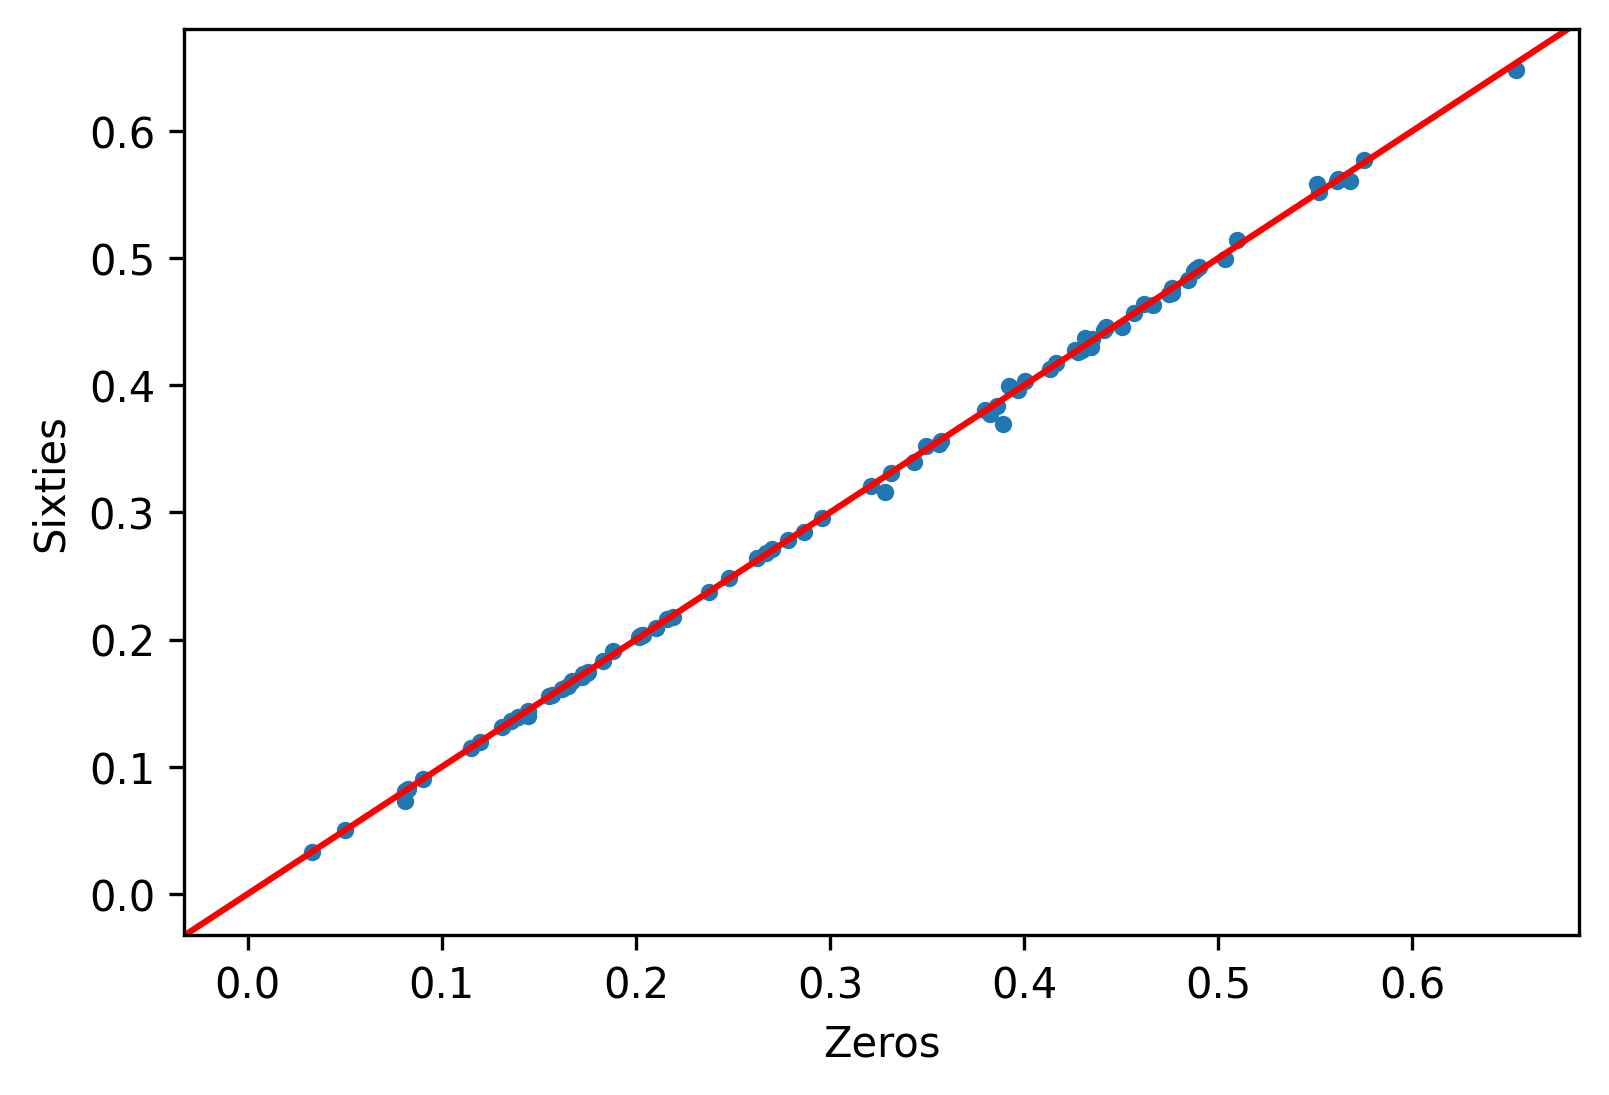

In [12]:
zeros_vs_sixties = np.array(zeros_vs_sixties)
plt.scatter(zeros_vs_sixties[:, 0], zeros_vs_sixties[:, 1], marker="o", s=10)
plt.axline((0, 0), slope=1, color = "red")
plt.xlabel("Zeros")
plt.ylabel("Sixties")
plt.savefig("0v60.png", dpi=300)
plt.gcf().set_dpi(300)

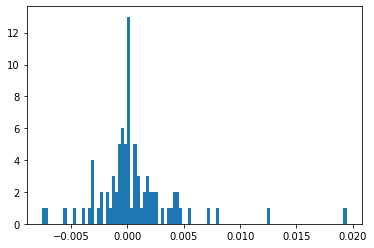

In [13]:
differences = [zeros_vs_sixties[i][0] - zeros_vs_sixties[i][1] for i in range(len(zeros_vs_sixties))]
_ = plt.hist(differences, bins=100)

In [14]:
gene_diff_percent_dict = {}

for response_gene in response_genes:
    gene_diff_percent_dict[data.columns[response_gene]] = 100*(test_loss_dict[(0, response_gene)] - test_loss_dict[(60, response_gene)])/test_loss_dict[(0, response_gene)]

In [15]:
gene_diff_percent_dict

{'Ace2': 0.48927778181146125,
 'Aldh1l1': 0.7999560721184102,
 'Amigo2': 0.4523521584259351,
 'Ano3': 0.415122557647662,
 'Aqp4': 1.2712961576153656,
 'Ar': 0.9894540286166502,
 'Arhgap36': -0.14942230079529117,
 'Baiap2': 0.650091016294438,
 'Ccnd2': 0.6478457731624481,
 'Cd24a': 0.33060943520510416,
 'Cdkn1a': 0.22546159416754508,
 'Cenpe': 0.05398196847126671,
 'Chat': 0.06950880604548103,
 'Coch': -0.2098135296562649,
 'Col25a1': -0.9742270535503141,
 'Cplx3': -0.36453407244942415,
 'Cpne5': 3.8365818738433517,
 'Creb3l1': -0.49143421370429013,
 'Cspg5': -0.0006472002963965161,
 'Cyp19a1': -0.22912208478049018,
 'Cyp26a1': 0.00037786371156354196,
 'Dgkk': 0.872442698791617,
 'Ebf3': 3.204349493258961,
 'Egr2': 0.0965278909857787,
 'Ermn': 5.00090417437386,
 'Esr1': 0.07171151310791178,
 'Etv1': 0.17161675881249738,
 'Fbxw13': -0.00787045618110555,
 'Fezf1': -0.3226648079418617,
 'Gbx2': -0.0035363138025253887,
 'Gda': -0.2918845532757459,
 'Gem': 0.5803633380511385,
 'Gjc3': 0.0594

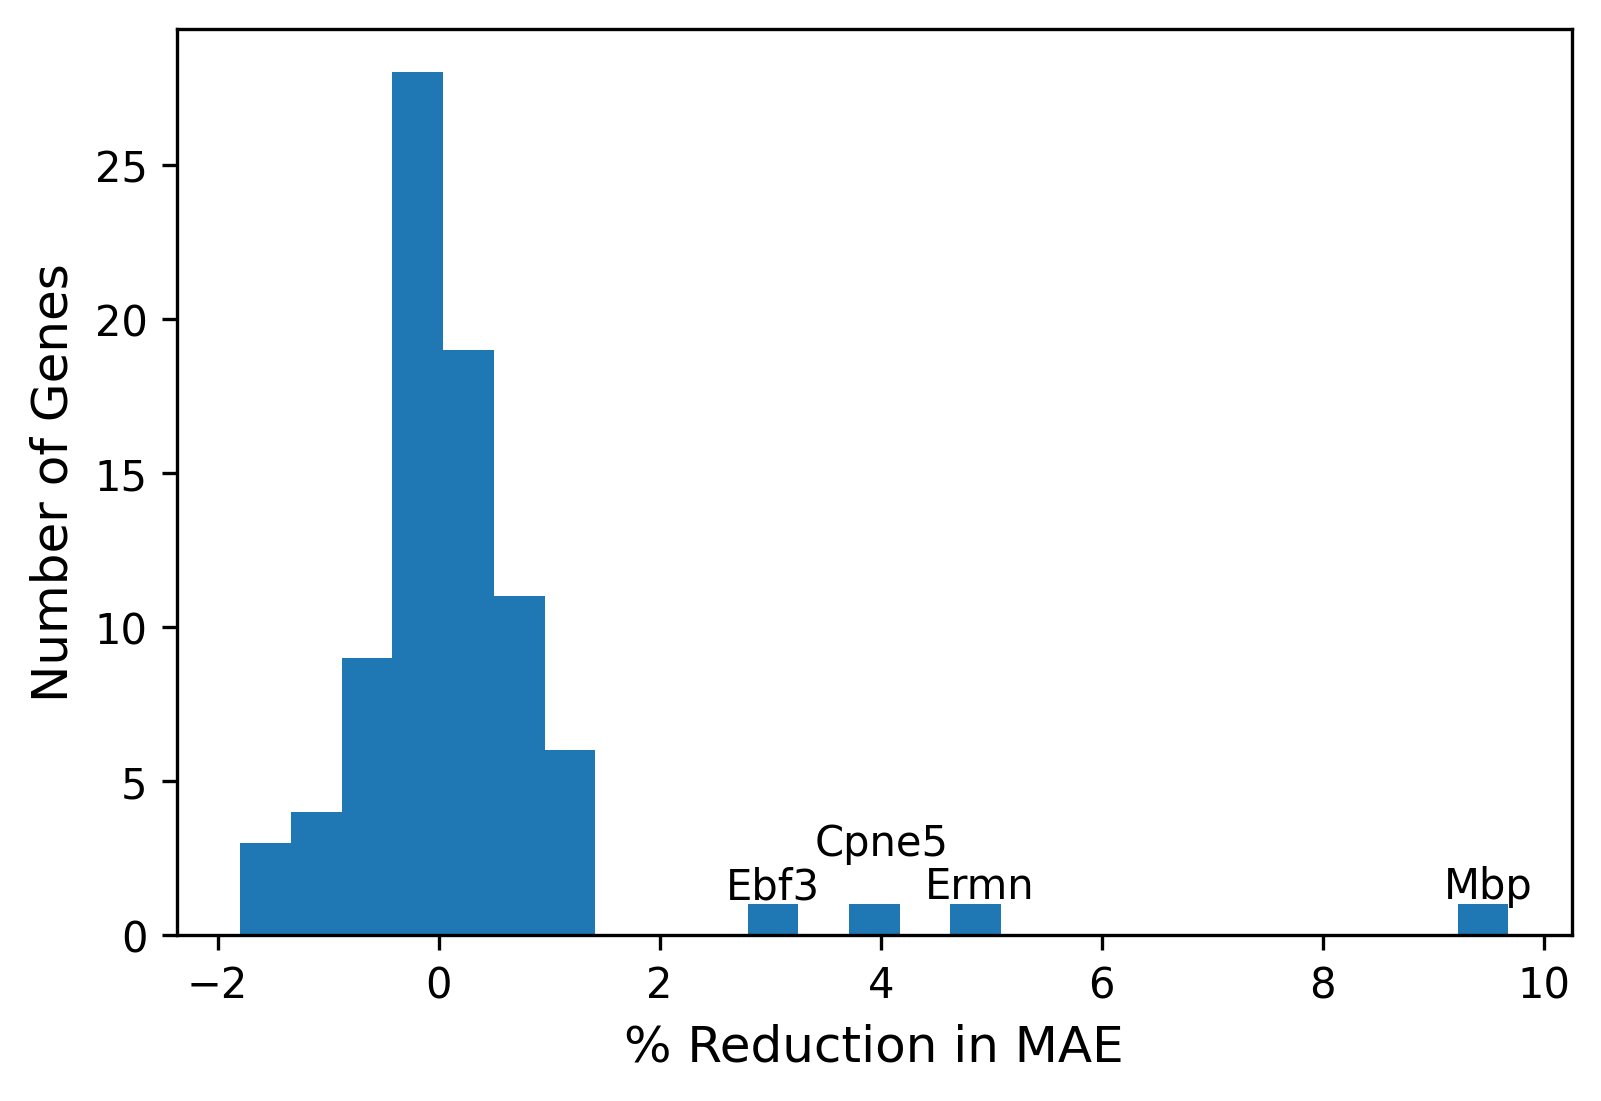

In [16]:
percent_differences = [100*(zeros_vs_sixties[i][0] - zeros_vs_sixties[i][1])/zeros_vs_sixties[i][0] for i in range(len(zeros_vs_sixties))]
_ = plt.hist(percent_differences, bins=25)
# plt.title("Percent reduction in MAE for genes \n in the MERFISH hypothalamus dataset", fontsize=14)
plt.xlabel("% Reduction in MAE", fontsize=12)
plt.ylabel("Number of Genes", fontsize=12)
plt.annotate("Ebf3", (2.6, 1.2), fontsize=10)
plt.annotate("Ermn", (4.4, 1.2), fontsize=10)
plt.annotate("Cpne5", (3.4, 2.6), fontsize=10)
plt.annotate("Mbp", (9.1, 1.2), fontsize=10)
plt.savefig("MLCB.png", dpi=300)
plt.gcf().set_dpi(300)
_ = plt.show()

In [17]:
min(differences), np.quantile(differences, 0.25), np.median(differences), np.quantile(differences, 0.75), max(differences)

(-0.0075730085372924805,
 -0.00080079585313797,
 3.0994415283203125e-05,
 0.0017355643212795258,
 0.019450396299362183)

In [18]:
min(percent_differences), np.quantile(percent_differences, 0.25), np.median(percent_differences), np.quantile(percent_differences, 0.75), max(percent_differences)

(-1.7951770122461292,
 -0.3686660292228641,
 0.01107550951737072,
 0.49635681684354627,
 9.680050010440238)